# End to End Inference Tutorial
Here we implement a complete end-to-end use of paltas. This notebook is intended as a 'minimal reproducible example', and thus doesn't use the full extent of the package, but should be a useful starting point. \
A number of the code-blocks simply run command-line instructions. This is intentional, as paltas is designed to run in the command-line. Furthermore, running such command-line statements allows easier transfer to remote computing clusters/parallelisation.


# Goals

1. To be able to implement a simple end-to-end example of Paltas
2. To understand how each of the packages inter-communicate, and which packages need to be run (and when), to perform hierarchichal inference.

# Import Packages
Here we import the required packages and define the training and model directories (where the training images and model weights are stored, respectively).\
The '/home/runner/work' referred to here is required to run this notebook as a Github Action, but should be changed to a prefered directory when running this notebook locally.\
Although tensorflow, emcee and ipython do not form part of the requirements for paltas, they are required for this notebook.

In [2]:
#paltas_directory = './'
#training_directory = '/home/runner/work/notebooks/End_to_End_Tutorial_Files/' #For github actions
#model_directory = '/home/runner/work/notebooks/End_to_End_Tutorial_Files/'
#training_directory = '/global/u2/p/phil1884/paltas/notebooks/End_to_End_Tutorial_Files' #For NERSC
#model_directory = '/global/u2/p/phil1884/paltas/notebooks/End_to_End_Tutorial_Files'
#paltas_directory = '/global/u2/p/phil1884/paltas/'
training_directory = '/mnt/extraspace/hollowayp/paltas_data/Example_SL_7/' #For Glamdring
model_directory = '/mnt/extraspace/hollowayp/paltas_data/Example_SL_7/'
paltas_directory = '/mnt/zfsusers/hollowayp/paltas/'
import os
os.chdir(paltas_directory)
from paltas.Analysis import hierarchical_inference,dataset_generation, loss_functions, conv_models
from IPython.display import display,Pretty
import matplotlib.pyplot as pl
from scipy.stats import norm
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import corner
import emcee
import numba
import h5py
import glob
import sys
random_seed = 4
np.random.seed(random_seed)
tf.random.set_seed(random_seed)


2023-10-31 18:44:51.523885: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-31 18:44:54.438413: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-31 18:44:54.438463: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-31 18:44:54.438495: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-31 18:44:54.774434: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-31 18:44:54.775206: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

# Generate Images
We start by generating lensed images divided into training and validation sets. The images are saved within one h5 file for each run of generate.py. We'll first look at the configuration file used to determine the properties of the generated images:

In [5]:
display(Pretty(glob.glob(f'{training_directory}/training/1/config*')[0]))

# Includes a PEMD deflector with external shear, and Sersic sources. 
# Designed to be similar to LSST-like images (though background noise is not yet implemented.)

import numpy as np
from scipy.stats import norm, truncnorm, uniform
paltas_directory = '/Users/hollowayp/paltas/'
import sys
sys.path.append(paltas_directory)
import paltas.Sampling.distributions as dist

from paltas.MainDeflector.simple_deflectors import PEMDShear
from paltas.Sources.sersic import SingleSersicSource
from paltas.Substructure.subhalos_dg19 import SubhalosDG19

# Define the numerics kwargs.
kwargs_numerics = {'supersampling_factor':1}

# This is always the number of pixels for the CCD. If drizzle is used, the
# final image will be larger.
numpix = 60

# Define some general image kwargs for the dataset
mask_radius = 0
mag_cut = 3.0

# Define arguments that will be used multiple times
output_ab_zeropoint = 27.79

config_dict = {
'main_deflector':{
'class': PEMDShear,
'parameters':{
'M200': 1e13,
'z_lens':trunc

We then run the image generation:

In [8]:
!python3 ./paltas/generate.py ./paltas/Configs/Examples/config_simple_tutorial.py /$training_directory/training/1 --n 100 --tf_record --h5
!python3 ./paltas/generate.py ./paltas/Configs/Examples/config_simple_tutorial.py /$training_directory/validation/1 --n 100 --tf_record --h5

2023-09-22 15:12:57.374073: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 15:12:58.158053: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/global/homes/p/phil1884/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/r

# Train Model
The neural network is then trained. The --h5 indicates that the images were originally saved as h5 files, and should be retrieved as such. Again, most of the work is done by the configration file, so we'll inspect that first. We define the learning parameters (the lens properties the network should determine), in this file - we chose the Einstein radius, shear, power-law slope, position and ellipticity in this example. 

In [10]:
display(Pretty("./paltas/Analysis/AnalysisConfigs/train_config_examp_tutorial.py"))

import os
from glob import glob
import numpy as np
batch_size = 256
# The number of epochs to train for
n_epochs = 5
# The size of the images in the training set
img_size = (60,60,1)
# A random seed to us
random_seed = 2
# The list of learning parameters to use
learning_params = ['main_deflector_parameters_theta_E',
	'main_deflector_parameters_gamma1','main_deflector_parameters_gamma2',
	'main_deflector_parameters_gamma','main_deflector_parameters_e1',
	'main_deflector_parameters_e2','main_deflector_parameters_center_x',
	'main_deflector_parameters_center_y']
log_learning_params = []
# Which parameters to consider flipping
flip_pairs = None
# Which terms to reweight
weight_terms = None

#directory_to_save_model = '/home/runner/work/notebooks/End_to_End_Tutorial_Files/' #Github actions
#directory_for_training_images =  '/home/runner/work/notebooks/End_to_End_Tutorial_Files/'
#directory_for_validation_images =  '/home/runner/work/notebooks/End_to_End_Tutorial_Files/'
directory_to_save_mo

In [16]:
!python3 ./paltas/Analysis/train_model.py ./paltas/Analysis/AnalysisConfigs/train_config_examp_tutorial.py --h5

2023-09-22 15:20:04.007997: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 15:20:04.904279: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/global/homes/p/phil1884/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/r

# Generate Model Predictions
Having trained the model, we locate the filename of the final epoch (this can be hardcoded instead if desired).

In [3]:
def load_model_weights_list(directory):
    """ Function to return a list of weights filenames from the network
    args: Directory containing the training, validation and weights files """
    weights_list = glob.glob(f'{directory}/model_weights/*')
    weights_list = [elem.split('model_weights/')[1] for elem in weights_list]
    return weights_list

def return_final_epoch_weights(directory):
    """ File to return the weight filename of the final trained epoch
    args: Directory containing the training, validation and weights files """
    weights_list = load_model_weights_list(directory)
    print(weights_list)
    final_epoch =  np.max([int(elem.split('-')[0]) for elem in weights_list])
    w_filename = [x for x in weights_list if x.startswith("{:02d}".format(final_epoch)+'-')][0]
    print('FINAL EPOCH',w_filename)
    return directory+'/model_weights/'+w_filename

def return_list_of_weight_files(directory):
    '''Returns list of weight files, ordered by their creation date'''
    files = list(filter(os.path.isfile, glob.glob(f'{directory}/model_weights/*h5')))
    files.sort(key=lambda x: os.path.getmtime(x))
    return files

final_weights_filename = return_final_epoch_weights(model_directory)

def retrieve_training_prior():
    prior_path = glob.glob(f'{training_directory}/**/norm*',recursive=True)[0]
    print(f'Retrieving prior path from {prior_path}')
    training_prior_db = pd.read_csv(prior_path)
    return training_prior_db

prior_db = retrieve_training_prior()
prior_db_indx = prior_db.set_index(prior_db['parameter'])
print('NOTE: This training prior should really encompass all the training images, not just a subset (i.e. not just one folder of them)')

['04--2.72.h5', '12--3.12.h5', '08--2.97.h5', '10--2.73.h5', '03--2.16.h5', '05--2.70.h5', '01--0.80.h5', '01-1.30.h5', '11--3.12.h5', '01--2.71.h5', '09--3.26.h5', '02--1.20.h5']
FINAL EPOCH 12--3.12.h5
Retrieving prior path from /mnt/extraspace/hollowayp/paltas_data/Example_SL_7/training/61/norms.csv
NOTE: This training prior should really encompass all the training images, not just a subset (i.e. not just one folder of them)


## Configuration
The trained model is loaded (along with the network weights from the final epoch).

In [4]:
def load_model(model_weights_filename,loss_type,model_type,learning_params,log_learning_params,img_size):
    """ Loads the trained model
    args: 
    model_weights_filename (str): .h5 file containing the weights of the trained model.
    loss_type (str): 'full' or 'diag', depending on the type of covariance matrix chosen
    model type (str): 'xresnet34' or 'xresnet101', according to the choice of network
    learning_params (list of str): Parameters learnt by the network
    img_size (int): Dimensions of the input images"""
    num_params = len(learning_params+log_learning_params)
    if loss_type == 'full':
        num_outputs = num_params + int(num_params*(num_params+1)/2)
        loss_func = loss_functions.FullCovarianceLoss(num_params)
    elif loss_type == 'diag':
        num_outputs = 2*num_params
        loss_func = loss_functions.DiagonalCovarianceLoss(num_params)
    if model_type == 'xresnet101':
        model = conv_models.build_xresnet101(img_size,num_outputs)
    if model_type == 'xresnet34':
        model = conv_models.build_xresnet34(img_size,num_outputs)
    model.load_weights(model_weights_filename,by_name=True,skip_mismatch=True)
    return model,loss_func,num_params

#Import training configs
print("NB: Need to make sure the following is importing the correct training configuration file: Currently loading train_config_Simpipeline")
from paltas.Analysis.AnalysisConfigs.train_config_Simpipeline import learning_params,batch_size,flip_pairs,\
                                                               n_epochs,random_seed,norm_images,\
                                                               loss_function,model_type,\
                                                               npy_folders_train,img_size


corner_param_print= [elem.replace('main_deflector_parameters_','').replace('subhalo_parameters_','').\
                     replace('theta','\Theta').replace('gamma','\gamma') for elem in learning_params]

model_dict = {}
for ii,epoch_i_weights in tqdm(enumerate(return_list_of_weight_files(model_directory))):
    if ii==0:
        model,loss_func,num_params = load_model(epoch_i_weights,loss_function,learning_params=learning_params,\
                             log_learning_params=[],model_type=model_type,img_size=img_size)
        model_dict[ii]=model
    else: 
        model,_,_ = load_model(epoch_i_weights,loss_function,learning_params=learning_params,\
                        log_learning_params=[],model_type=model_type,img_size=img_size)
        model_dict[ii]=model

NB: Need to make sure the following is importing the correct training configuration file: Currently loading train_config_Simpipeline
Using 101 training folders, e.g. /mnt/extraspace/hollowayp/paltas_data/Example_SL_7//training/61)
['04--2.72.h5', '12--3.12.h5', '08--2.97.h5', '10--2.73.h5', '03--2.16.h5', '05--2.70.h5', '01--0.80.h5', '01-1.30.h5', '11--3.12.h5', '01--2.71.h5', '09--3.26.h5', '02--1.20.h5']
FINAL EPOCH 12--3.12.h5


12it [01:14,  6.17s/it]


In [5]:
return_list_of_weight_files(model_directory)

['/mnt/extraspace/hollowayp/paltas_data/Example_SL_7//model_weights/01-1.30.h5',
 '/mnt/extraspace/hollowayp/paltas_data/Example_SL_7//model_weights/01--0.80.h5',
 '/mnt/extraspace/hollowayp/paltas_data/Example_SL_7//model_weights/02--1.20.h5',
 '/mnt/extraspace/hollowayp/paltas_data/Example_SL_7//model_weights/03--2.16.h5',
 '/mnt/extraspace/hollowayp/paltas_data/Example_SL_7//model_weights/04--2.72.h5',
 '/mnt/extraspace/hollowayp/paltas_data/Example_SL_7//model_weights/05--2.70.h5',
 '/mnt/extraspace/hollowayp/paltas_data/Example_SL_7//model_weights/01--2.71.h5',
 '/mnt/extraspace/hollowayp/paltas_data/Example_SL_7//model_weights/08--2.97.h5',
 '/mnt/extraspace/hollowayp/paltas_data/Example_SL_7//model_weights/09--3.26.h5',
 '/mnt/extraspace/hollowayp/paltas_data/Example_SL_7//model_weights/10--2.73.h5',
 '/mnt/extraspace/hollowayp/paltas_data/Example_SL_7//model_weights/11--3.12.h5',
 '/mnt/extraspace/hollowayp/paltas_data/Example_SL_7//model_weights/12--3.12.h5']

## Generate Network Predictions
The network predictions are then loaded, for testing on the validation set generated above

In [7]:
def gen_network_predictions(test_folder,norm_path,learning_params,log_learning_params,loss_type,
                            loss_func,model,shuffle=True,
                            norm_images=True,log_norm_images=False):
    """
    Generate neural network predictions given a paltas generated folder of images

    Args:
        test_folder (string): Path to folder of paltas generated images, 
            containig a data.tfrecord file
        norm_path (string): Path to .csv containing normalization of parameters
            applied during training of network
        learning_params (list(string)): Names of parameters learned
        loss_type (string): only 'diag' currently supported for this notebook
        loss_func (paltas.Analysis.loss_function): Loss function object, (needs
            draw_samples() and convert_output() functionality)
        model (paltas.Analysis.conv_models): Trained neural network with weights
            loaded
        shuffle (bool, default=True): If True, the order of the test set is shuffled
            when generating predictions
        norm_images (bool, default=True): If True, normalize test set images
        log_norm_images (bool, default=False): If True, test set imags are
            log-normalized and rescaled to range (0,1)

    Returns:
        y_test, y_pred, std_pred, prec_pred
    """

    tfr_test_path = os.path.join(test_folder,'data.tfrecord')
    input_norm_path = norm_path
    #The following code implementation here and in the hierarchical inference function below assumes a diagonal covariance matrix
    if loss_type !='diag':
        raise ValueError('loss_type not supported in this notebook')
    tf_dataset_test = dataset_generation.generate_tf_dataset(tf_record_path = tfr_test_path,\
                                                             learning_params = learning_params,
                                                             batch_size = 3,\
                                                             n_epochs = 1,\
                                                             norm_images=norm_images,
                                                             kwargs_detector=None,\
                                                             input_norm_path=input_norm_path,
                                                             log_learning_params=log_learning_params,\
                                                             shuffle=shuffle)

    y_test_list = [];y_pred_list = []
    std_pred_list = [];cov_pred_list = []
    predict_samps_list = []

    for batch in tf_dataset_test:
        images = batch[0].numpy()
        y_test = batch[1].numpy()
        
        # use unrotated output for covariance matrix
        output = model.predict(images)
        y_pred, log_var_pred = loss_func.convert_output(output)

        # compute std. dev.
        std_pred = np.exp(log_var_pred/2)
        cov_mat = np.empty((len(std_pred),len(std_pred[0]),len(std_pred[0])))
        for i in range(len(std_pred)):
            cov_mat[i] = np.diag(std_pred[i]**2)

        y_test_list.append(y_test)
        y_pred_list.append(y_pred)
        std_pred_list.append(std_pred)
        cov_pred_list.append(cov_mat)

    y_test = np.concatenate(y_test_list)
    y_pred = np.concatenate(y_pred_list)
    std_pred = np.concatenate(std_pred_list)
    cov_pred = np.concatenate(cov_pred_list)

    if input_norm_path is not None:
        dataset_generation.unnormalize_outputs(input_norm_path,learning_params+log_learning_params,
                                        y_pred,standard_dev=std_pred,cov_mat=cov_pred)
        dataset_generation.unnormalize_outputs(input_norm_path,learning_params+log_learning_params,
                                        y_test)
    prec_pred = np.linalg.inv(cov_pred)
   
    return y_test, y_pred, std_pred, prec_pred

In [8]:
network_predictions_dict = {}
for epoch_i in tqdm(list(model_dict.keys())):
     network_predictions_dict[epoch_i] = gen_network_predictions(\
                        test_folder=training_directory+'/validation/1',\
                        norm_path=glob.glob(f'{training_directory}/**/norm*',recursive=True)[0],
                        #norm_path = training_directory+'/training/1/norms.csv',\
                        learning_params=learning_params,\
                        log_learning_params = [],\
                        loss_type=loss_function,
                        loss_func=loss_func,\
                        model=model_dict[epoch_i],
                        shuffle=True,
                        norm_images=norm_images,
                        log_norm_images=False)

  0%|          | 0/12 [00:00<?, ?it/s]/mnt/zfsusers/hollowayp/paltas/paltas/Analysis/dataset_generation.py:277: UserWarning: No noise will be added
  warnings.warn('No noise will be added')


1/1 [==============================] - 0s 25ms/step


  8%|▊         | 1/12 [00:27<04:59, 27.21s/it]/mnt/zfsusers/hollowayp/paltas/paltas/Analysis/dataset_generation.py:277: UserWarning: No noise will be added
  warnings.warn('No noise will be added')


1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 2/12 [00:50<04:11, 25.11s/it]/mnt/zfsusers/hollowayp/paltas/paltas/Analysis/dataset_generation.py:277: UserWarning: No noise will be added
  warnings.warn('No noise will be added')


1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 3/12 [01:14<03:40, 24.44s/it]/mnt/zfsusers/hollowayp/paltas/paltas/Analysis/dataset_generation.py:277: UserWarning: No noise will be added
  warnings.warn('No noise will be added')


1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 4/12 [01:38<03:14, 24.33s/it]/mnt/zfsusers/hollowayp/paltas/paltas/Analysis/dataset_generation.py:277: UserWarning: No noise will be added
  warnings.warn('No noise will be added')


1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 5/12 [02:03<02:50, 24.41s/it]/mnt/zfsusers/hollowayp/paltas/paltas/Analysis/dataset_generation.py:277: UserWarning: No noise will be added
  warnings.warn('No noise will be added')


1/1 [==============================] - 0s 31ms/step


 50%|█████     | 6/12 [02:26<02:24, 24.16s/it]/mnt/zfsusers/hollowayp/paltas/paltas/Analysis/dataset_generation.py:277: UserWarning: No noise will be added
  warnings.warn('No noise will be added')


1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 7/12 [02:51<02:01, 24.31s/it]/mnt/zfsusers/hollowayp/paltas/paltas/Analysis/dataset_generation.py:277: UserWarning: No noise will be added
  warnings.warn('No noise will be added')


1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 8/12 [03:15<01:37, 24.29s/it]/mnt/zfsusers/hollowayp/paltas/paltas/Analysis/dataset_generation.py:277: UserWarning: No noise will be added
  warnings.warn('No noise will be added')


1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 9/12 [03:40<01:13, 24.40s/it]/mnt/zfsusers/hollowayp/paltas/paltas/Analysis/dataset_generation.py:277: UserWarning: No noise will be added
  warnings.warn('No noise will be added')


1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 10/12 [04:05<00:49, 24.75s/it]/mnt/zfsusers/hollowayp/paltas/paltas/Analysis/dataset_generation.py:277: UserWarning: No noise will be added
  warnings.warn('No noise will be added')


1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 11/12 [04:30<00:24, 24.55s/it]/mnt/zfsusers/hollowayp/paltas/paltas/Analysis/dataset_generation.py:277: UserWarning: No noise will be added
  warnings.warn('No noise will be added')


1/1 [==============================] - 0s 28ms/step


100%|██████████| 12/12 [04:54<00:00, 24.53s/it]


## Plot Network Output Distributions
We now plot the distributions of the network predictions, and compare those to the ground-truth

In [9]:
db_columns = [elem.replace('main_deflector_parameters_','') for elem in learning_params]
Error_db = {elem:pd.DataFrame(columns=db_columns) for elem in network_predictions_dict.keys()}

def RMS_error_func(pred,truth,db_columns):
    #Calculates RMS error
    RMS_error =np.sqrt(np.mean((pred-truth)**2,axis=0))
    print(f'{len(RMS_error)} dimensional output') 
    return {db_columns[i]:RMS_error[i] for i in range(len(db_columns))}

def MAE_func(pred,truth,db_columns):
    #Calculates mean absolute error
    MAE_error = np.mean(abs(pred-truth),axis=0) 
    print(f'{len(MAE_error)} dimensional output') 
    return {db_columns[i]:MAE_error[i] for i in range(len(db_columns))}

#RMS_error_func(network_predictions_dict[epoch_i][0],network_predictions_dict[epoch_i][1])

for epoch_i in network_predictions_dict.keys():
    Error_db[epoch_i] = pd.concat([Error_db[epoch_i],pd.DataFrame(data=MAE_func(network_predictions_dict[epoch_i][0],
                                                                                network_predictions_dict[epoch_i][1],
                                                                                db_columns),
                                                                index=np.array(['MAE']))])
    Error_db[epoch_i] = pd.concat([Error_db[epoch_i],pd.DataFrame(data=RMS_error_func(network_predictions_dict[epoch_i][0],
                                                                                      network_predictions_dict[epoch_i][1],
                                                                                      db_columns),
                                                                index=np.array(['RMS']))])

Error_db

7 dimensional output
7 dimensional output
7 dimensional output
7 dimensional output
7 dimensional output
7 dimensional output
7 dimensional output
7 dimensional output
7 dimensional output
7 dimensional output
7 dimensional output
7 dimensional output
7 dimensional output
7 dimensional output
7 dimensional output
7 dimensional output
7 dimensional output
7 dimensional output
7 dimensional output
7 dimensional output
7 dimensional output
7 dimensional output
7 dimensional output
7 dimensional output


{0:       theta_E    gamma1    gamma2        e1        e2  center_x  center_y
 MAE  0.048847  0.032956  0.044429  0.065027  0.110188  0.068257  0.070678
 RMS  0.065946  0.042149  0.054021  0.082421  0.130513  0.085806  0.088637,
 1:       theta_E    gamma1    gamma2        e1        e2  center_x  center_y
 MAE  0.046088  0.031125  0.031946  0.061010  0.073063  0.049332  0.048909
 RMS  0.062002  0.039634  0.041032  0.077213  0.091314  0.063997  0.063439,
 2:       theta_E    gamma1   gamma2        e1        e2  center_x  center_y
 MAE  0.040941  0.036049  0.03072  0.058369  0.058579  0.046257  0.043542
 RMS  0.053323  0.044361  0.03941  0.074680  0.075453  0.060318  0.057545,
 3:       theta_E    gamma1    gamma2        e1        e2  center_x  center_y
 MAE  0.039140  0.027515  0.028259  0.052758  0.050313  0.041202  0.041012
 RMS  0.050751  0.036332  0.036999  0.068575  0.065467  0.054685  0.054719,
 4:       theta_E    gamma1    gamma2        e1        e2  center_x  center_y
 MAE  0.0

In [10]:
import imageio
label_kwargs = {'fontsize': 20}
range_dict = {'main_deflector_parameters_theta_E':(0,3),
              'main_deflector_parameters_gamma1':(-0.5,0.5),
              'main_deflector_parameters_gamma2':(-0.5,0.5),
              'main_deflector_parameters_e1':(-0.5,0.5),
              'main_deflector_parameters_e2':(-0.5,0.5),
              'main_deflector_parameters_center_x':(-0.5,0.5),
              'main_deflector_parameters_center_y':(-0.5,0.5)}
bins_corner=20
gif_images = []
for epoch_i in tqdm(network_predictions_dict.keys()):
    fig = pl.figure(figsize=(3*len(learning_params),3*len(learning_params)))
    corner_kwargs_dict = {'fig':fig,'bins':bins_corner,'range':[range_dict[elem] for elem in learning_params]}
    corner.corner(network_predictions_dict[epoch_i][0],color='k',**corner_kwargs_dict)
    corner.corner(network_predictions_dict[epoch_i][1],color='red',\
                labels=['$'+elem+'$' for elem in corner_param_print],\
                label_kwargs=label_kwargs,
                **corner_kwargs_dict)
    pl.legend(['Truth','Pred'])
    pl.tight_layout()
#To save as a gif:
    pl.suptitle(f'Epoch {epoch_i}',fontsize=25,fontweight='bold')
    try:
        pl.savefig(f'{model_directory}/corner_plots/corner_plot_evolution_{epoch_i}.png')
    except:
        os.mkdir(f'{model_directory}/corner_plots/')
        pl.savefig(f'{model_directory}/corner_plots/corner_plot_evolution_{epoch_i}.png')
#    pl.show()
    pl.close()
    corner_i = imageio.imread(f'{model_directory}/corner_plots/corner_plot_evolution_{epoch_i}.png')
    gif_images.append(corner_i)

imageio.mimsave(f'{model_directory}/corner_plots/corner_plot_evolution.gif', gif_images,duration=2)


  0%|          | 0/12 [00:00<?, ?it/s]/tmp/ipykernel_2216/643890868.py:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  corner_i = imageio.imread(f'{model_directory}/corner_plots/corner_plot_evolution_{epoch_i}.png')
  8%|▊         | 1/12 [00:04<00:47,  4.33s/it]/tmp/ipykernel_2216/643890868.py:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  corner_i = imageio.imread(f'{model_directory}/corner_plots/corner_plot_evolution_{epoch_i}.png')
 17%|█▋        | 2/12 [00:08<00:39,  3.96s/it]/tmp/ipykernel_2216/643890868.py:31: DeprecationWarning: Starting with ImageIO v3 the behavior of th

## Load Model Outputs
The hyperparameters of the training set are loaded (to use as an interim prior in the hierarchical inference), along with the network predictions for the validation set

In [11]:
train_mean = np.array(pd.read_csv(glob.glob(f'{training_directory}/**/norm*',recursive=True)[0])['mean']) 
train_scatter = np.array(pd.read_csv(glob.glob(f'{training_directory}/**/norm*',recursive=True)[0])['std']) 

#Since we are using a diagonal covariance matrix, the precision matrix is the diagonal matrix of
#the (elementwise) values of 1/std^2. In general however it is inv(cov_matrix).
final_epoch = max(list(network_predictions_dict.keys()))
network_means = network_predictions_dict[final_epoch][1][:,:].astype('float64')              
network_prec = network_predictions_dict[final_epoch][3][:,:,:].astype('float64')

# Hierarchical Inference
The following performs hierarchical inference to retrieve the population hyperparameters of the validation set, assuming a diagonal covariance matrix.

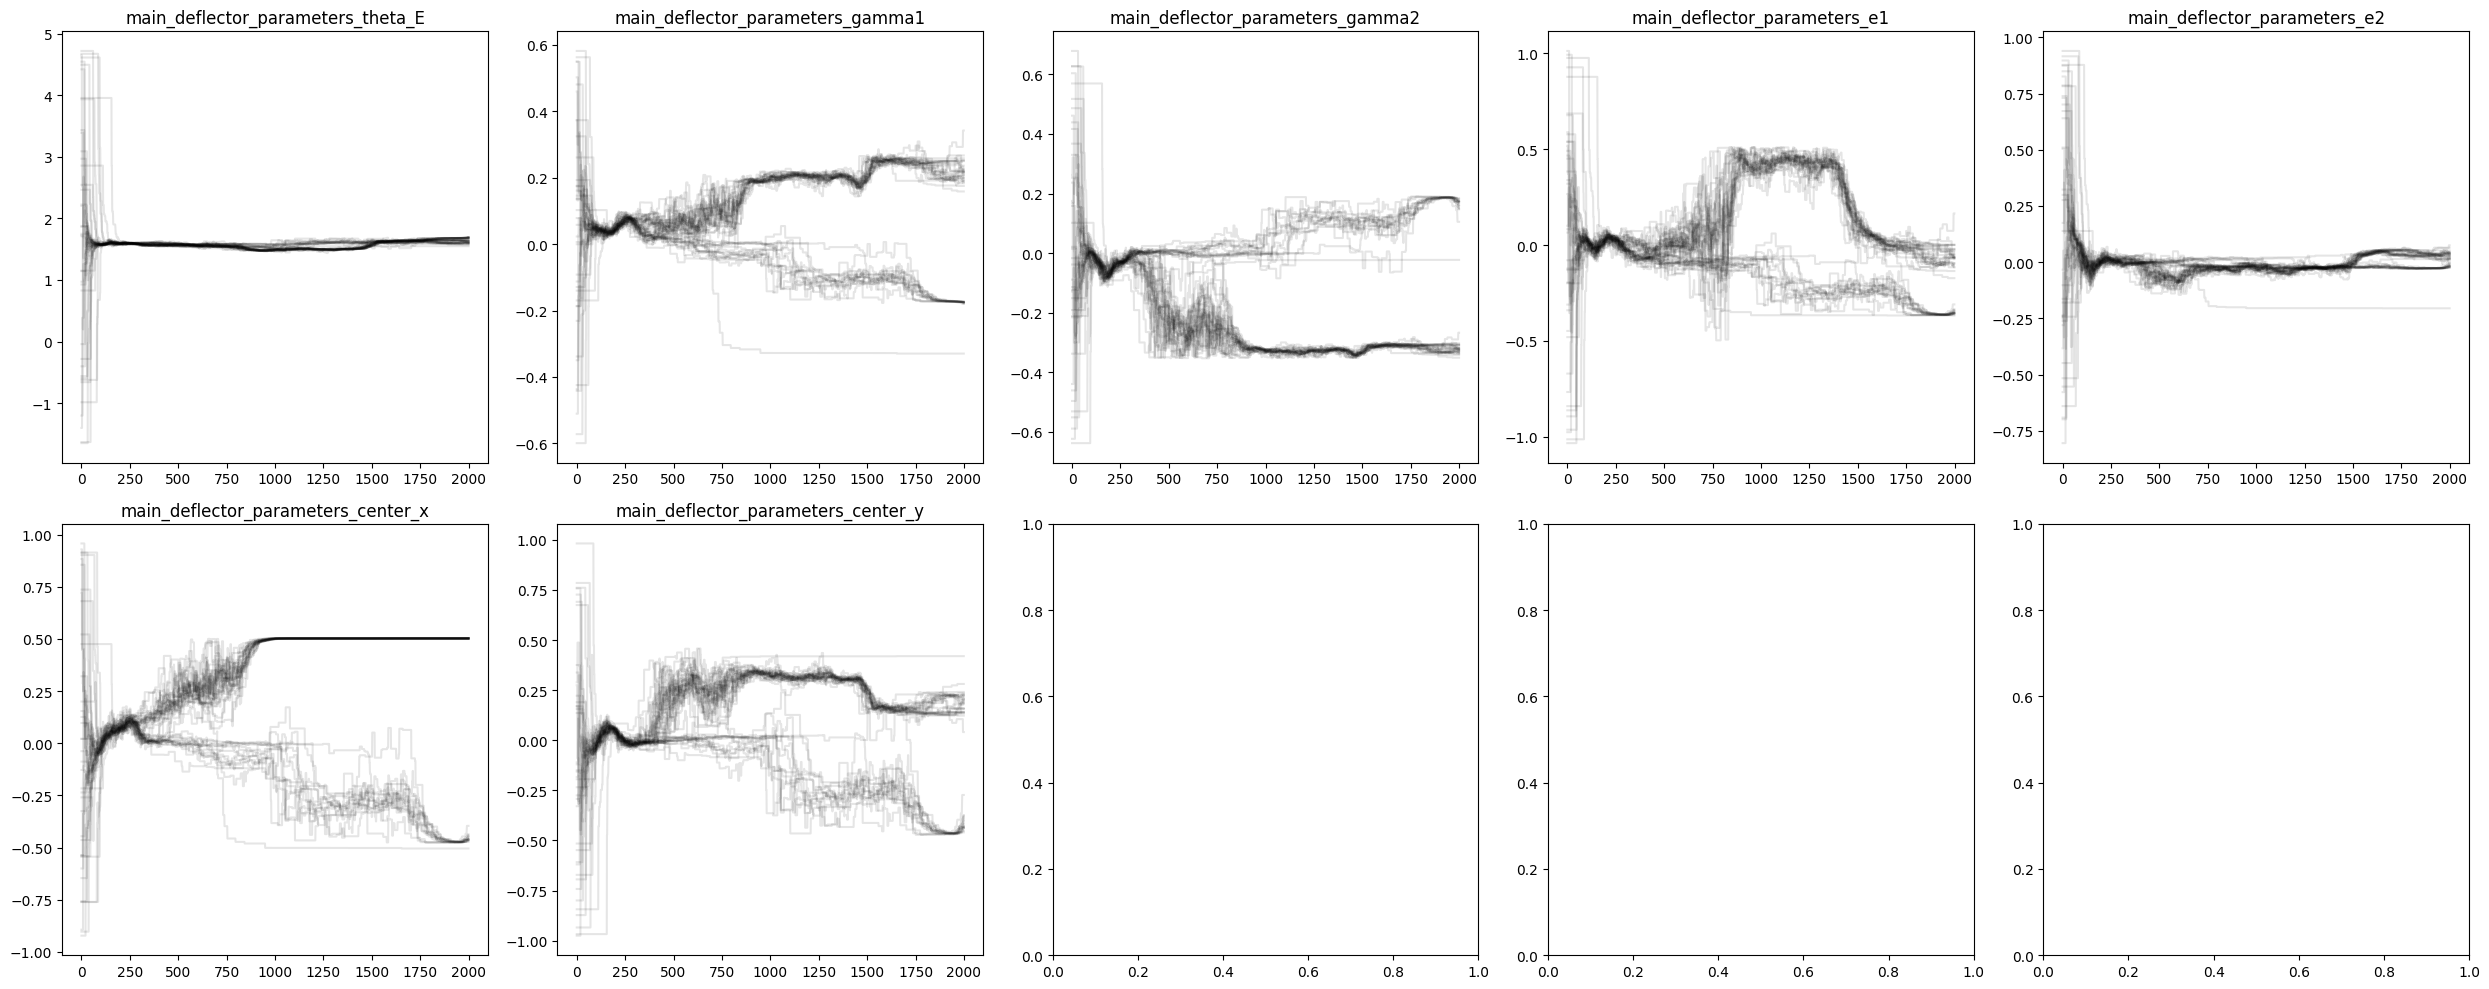

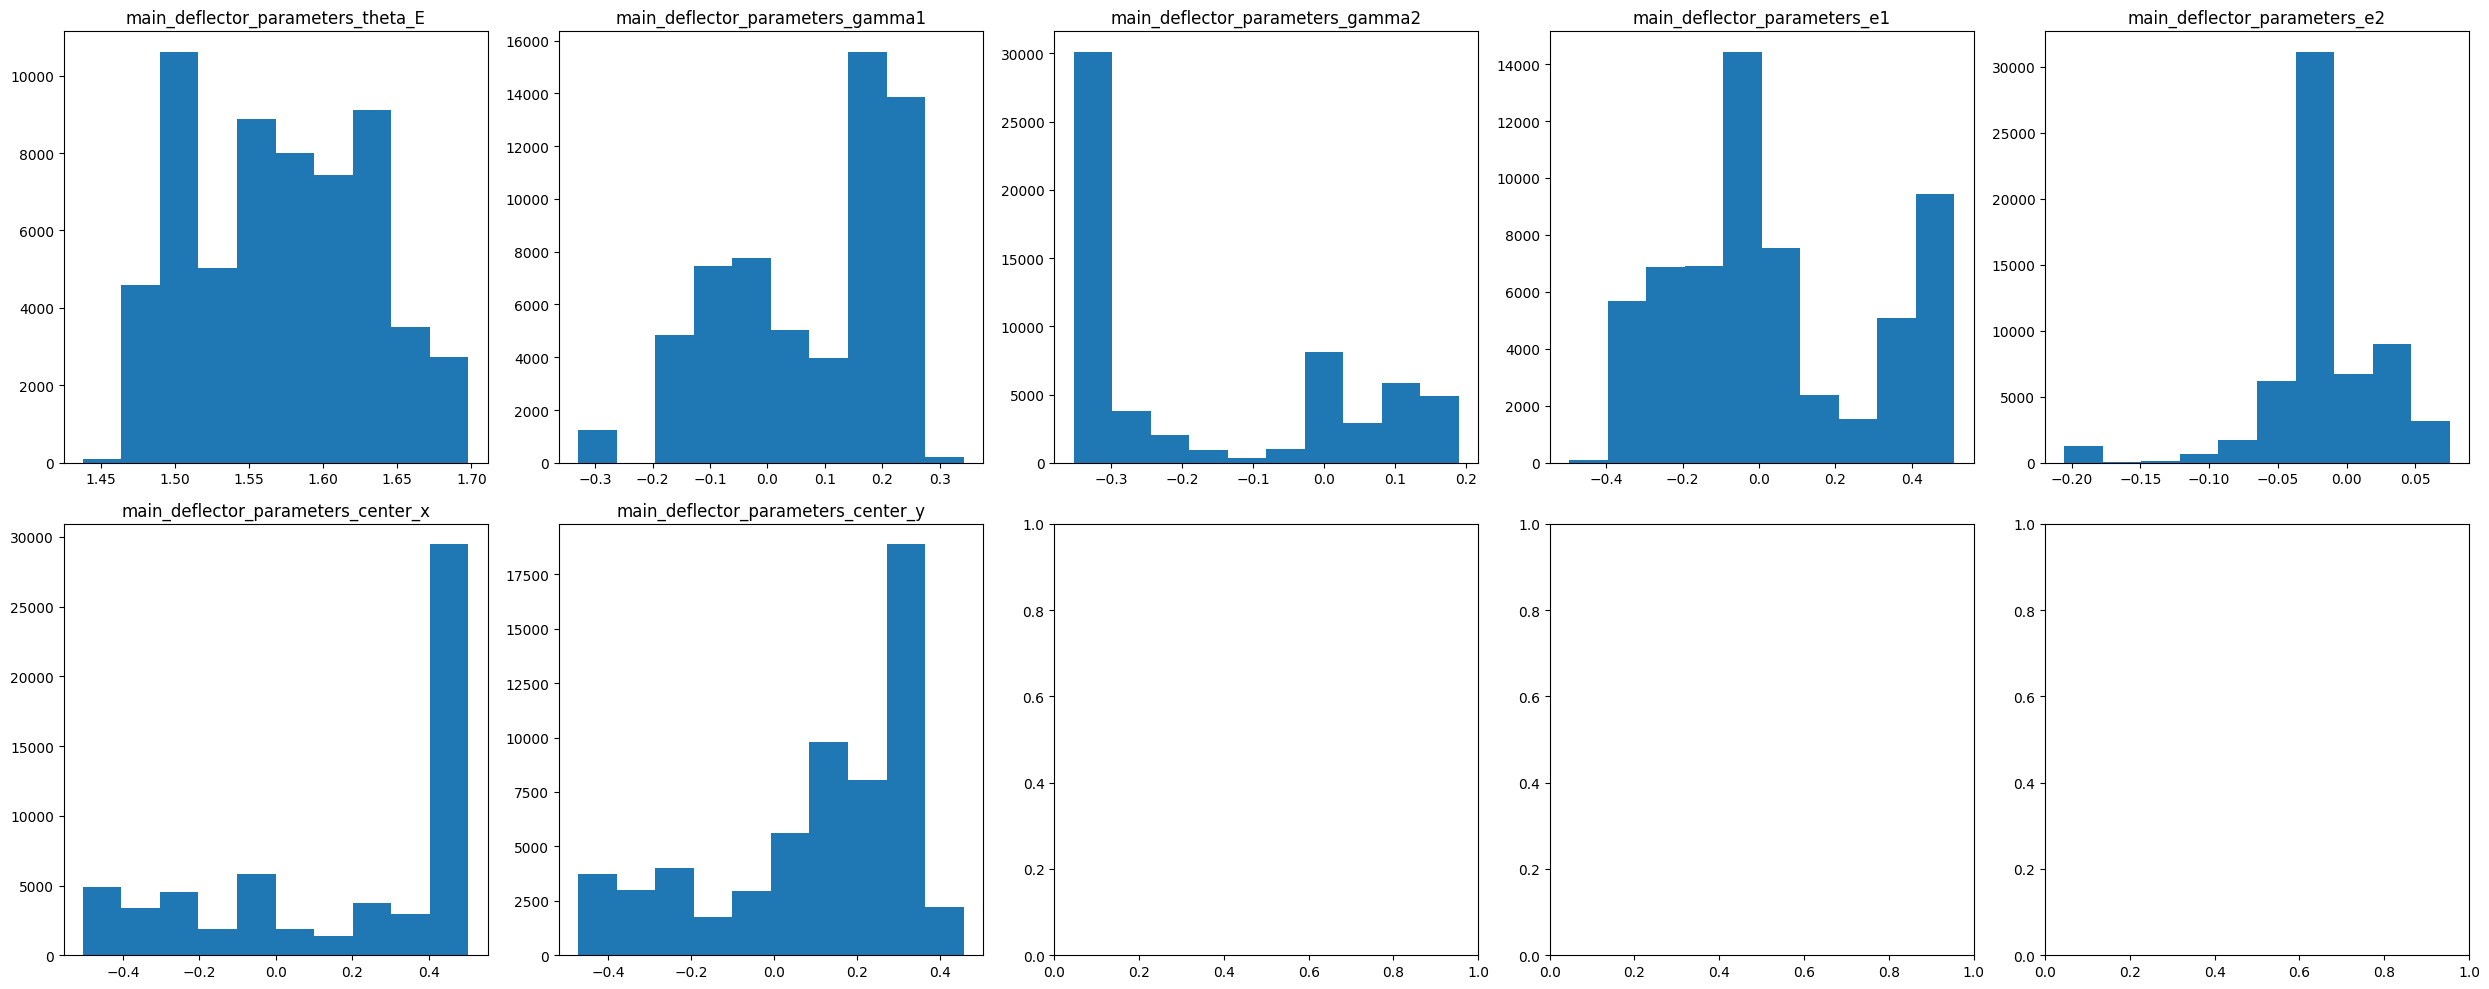

In [15]:
def plot_sampler_properties(plot_evolution=False,plot_post_burnin=False,burnin=500):
    #[walker,evolution_number,property]
    N_cols = np.ceil(len(learning_params)/5).astype('int')
    if plot_evolution:
        fig,ax = pl.subplots(N_cols,5,figsize=(25,5*N_cols))
        for prop_i in range(len(learning_params)):
            x = prop_i%5
            y = np.floor(prop_i/5).astype('int')
            for c_i in range(40):
                ax[y,x].plot(sampler.chain[c_i,:,prop_i],alpha=0.1,c='k')
                ax[y,x].set_title(learning_params[prop_i])
        pl.tight_layout()
        pl.show()
    if plot_post_burnin:
        fig,ax = pl.subplots(N_cols,5,figsize=(25,5*N_cols))
        for prop_i in range(len(learning_params)):
            x = prop_i%5
            y = np.floor(prop_i/5).astype('int')
            ax[y,x].hist(sampler.chain[:,burnin:,prop_i].flatten())
            ax[y,x].set_title(learning_params[prop_i])
        pl.tight_layout()
        pl.show()

plot_sampler_properties(plot_evolution=True,
                        plot_post_burnin=True)

In [12]:
#Adapted from https://github.com/smericks/deep-lens-modeling/blob/9ff7f79715f0dd47bb24b2e1d279c2fe78b792dd/mcmc_utils.py#L285

def hierarchical_inference_func(n_lenses,y_pred,prec_pred,train_mean,train_scatter,n_param=None,n_samps = 1e+4):
    """
    Returns:
        sampler object
    """
    # Load the predictions for the mean and covariance for our model. We'll have to do a little reshaping here since the code
    # expect an array of mean values and a precision matrix.
    y_pred_hi = y_pred
    prec_pred_hi = prec_pred
    # The interim training distribution.
    mu_omega_i = np.array(train_mean)
    cov_omega_i = np.diag(np.array(train_scatter)**2)
    if n_param is None: ndim = 2*num_params
    else: ndim = 2*n_param
    # uniform prior with bounds
    @numba.njit()
    def eval_func_omega(hyperparameters):
        #sig_learning_params = [0.15,0.05,0.05,0.1,0.1,0.1,0.16,0.16]
        sig_learning_params = [0.3262236573360147, 0.0691578311503941, 0.0707532538460401, 0.1039486254170555, 0.0928868692886493, 0.100720927145516, 0.1010153184827978]
        #loc_learning_params = [1.1,0,0,0,0,0,0] #[1.1,0,0,2,0,0,0,0]
        loc_learning_params = [1.5690661105325276, 0.0024534948897665, 0.0002774614507535, -0.0075663111577294, 0.0685743873539934, -0.0011395989404728, -0.0001727756120318]
        for i in range(len(sig_learning_params)):
            if abs(hyperparameters[i]-loc_learning_params[i])>5*sig_learning_params[i]:
                return -np.inf
        # log prior for uniform in sigma space, as opposed to uniform in log space
        return 0 #np.sum(hyperparameters[int(ndim/2):])

    # Initialize our class and then give it the network predictions. These are set to global variables in case you want to use
    # pooling.
    prob_class = hierarchical_inference.ProbabilityClassAnalytical(mu_omega_i,cov_omega_i,eval_func_omega)
    prob_class.set_predictions(mu_pred_array_input=y_pred_hi,prec_pred_array_input=prec_pred_hi)

    # Set a few of the parameters we will need to pass to emcee
    n_walkers = 40
    # Generate an initial state informed by prior range.
    # UPDATE: If these ranges are too wide (e.g. outside the training prior), I don't think the walkers will ever see anywhere with a non-zero loss (as set loss to
    # -inf above), so they won't ever evolve/walk anywhere.
    cur_state_mu = np.concatenate([np.random.uniform(low=prior_db_indx.loc[elem]['mean']-10*prior_db_indx.loc[elem]['std'],
                                                     high=prior_db_indx.loc[elem]['mean']+10*prior_db_indx.loc[elem]['std'] ,
                                                     size=(n_walkers,1)) for elem in learning_params],axis=1)
    cur_state_sigmas = np.log(np.concatenate([np.random.uniform(low=0.01,high=0.1,size=(n_walkers,1))\
                                   for i in range(int(ndim/2))],axis=1))
    cur_state = np.concatenate((cur_state_mu,cur_state_sigmas),axis=1)
    sampler = emcee.EnsembleSampler(n_walkers, ndim, prob_class.log_post_omega)
    _ = sampler.run_mcmc(cur_state,n_samps,progress=True,skip_initial_state_check=True)
 
    return sampler

In [13]:
#Due to the current implementation of hierarchical_inference.ProbabilityClassAnalytical.log_post_omega, we assert
#that the covariance matrix must be diagonal for now.
assert loss_function=='diag'
burnin = int(100)

sampler = hierarchical_inference_func(1000,network_means,network_prec,\
                      train_mean[:].astype('float64'),train_scatter[:].astype('float64'),n_samps=2000)
chain = sampler.chain[:,burnin:,:].reshape((-1,2*num_params))[:,0:num_params] #Just using the means for now

  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/zfsusers/hollowayp/python11_env/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/mnt/zfsusers/hollowayp/python11_env/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 48/2000 [00:09<07:15,  4.48it/s]/mnt/zfsusers/hollowayp/paltas/paltas/Analysis/hierarchical_inference.py:400: RuntimeWarning: Singular covariance matrix
  warnings.warn('Singular covariance matrix',


Matrix is not positive definite.


  6%|▋         | 128/2000 [00:37<11:01,  2.83it/s]

Matrix is not positive definite.


  7%|▋         | 131/2000 [00:39<11:40,  2.67it/s]

Matrix is not positive definite.


  7%|▋         | 133/2000 [00:39<11:34,  2.69it/s]

Matrix is not positive definite.


  7%|▋         | 136/2000 [00:41<12:35,  2.47it/s]

Matrix is not positive definite.


  7%|▋         | 137/2000 [00:41<12:57,  2.39it/s]

Matrix is not positive definite.


  7%|▋         | 142/2000 [00:43<12:11,  2.54it/s]

Matrix is not positive definite.
Matrix is not positive definite.


  7%|▋         | 144/2000 [00:44<11:27,  2.70it/s]

Matrix is not positive definite.


  7%|▋         | 145/2000 [00:44<11:05,  2.79it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


  7%|▋         | 147/2000 [00:45<12:49,  2.41it/s]

Matrix is not positive definite.


  7%|▋         | 149/2000 [00:46<13:26,  2.29it/s]

Matrix is not positive definite.
Matrix is not positive definite.


  8%|▊         | 150/2000 [00:46<13:27,  2.29it/s]

Matrix is not positive definite.
Matrix is not positive definite.


  8%|▊         | 151/2000 [00:47<13:09,  2.34it/s]

Matrix is not positive definite.


  8%|▊         | 152/2000 [00:47<13:00,  2.37it/s]

Matrix is not positive definite.
Matrix is not positive definite.


  8%|▊         | 153/2000 [00:47<13:24,  2.30it/s]

Matrix is not positive definite.
Matrix is not positive definite.


  8%|▊         | 154/2000 [00:48<13:43,  2.24it/s]

Matrix is not positive definite.


  8%|▊         | 155/2000 [00:48<13:45,  2.23it/s]

Matrix is not positive definite.


  8%|▊         | 156/2000 [00:49<14:10,  2.17it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


  8%|▊         | 157/2000 [00:49<14:42,  2.09it/s]

Matrix is not positive definite.
Matrix is not positive definite.


  8%|▊         | 159/2000 [00:50<13:14,  2.32it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


  8%|▊         | 160/2000 [00:51<12:22,  2.48it/s]

Matrix is not positive definite.
Matrix is not positive definite.


  8%|▊         | 161/2000 [00:51<12:14,  2.50it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


  8%|▊         | 162/2000 [00:51<11:45,  2.61it/s]

Matrix is not positive definite.


  8%|▊         | 163/2000 [00:52<12:02,  2.54it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


  8%|▊         | 164/2000 [00:52<12:34,  2.43it/s]

Matrix is not positive definite.
Matrix is not positive definite.


  8%|▊         | 165/2000 [00:53<13:15,  2.31it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


  8%|▊         | 167/2000 [00:53<12:56,  2.36it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


  8%|▊         | 168/2000 [00:54<12:57,  2.36it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


  8%|▊         | 169/2000 [00:54<13:07,  2.33it/s]

Matrix is not positive definite.


  8%|▊         | 170/2000 [00:55<13:37,  2.24it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


  9%|▊         | 172/2000 [00:56<13:23,  2.28it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


  9%|▊         | 173/2000 [00:56<13:41,  2.22it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


  9%|▊         | 174/2000 [00:57<13:55,  2.19it/s]

Matrix is not positive definite.
Matrix is not positive definite.


  9%|▉         | 175/2000 [00:57<13:30,  2.25it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


  9%|▉         | 176/2000 [00:57<13:15,  2.29it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


  9%|▉         | 178/2000 [00:58<11:26,  2.65it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


  9%|▉         | 179/2000 [00:58<10:46,  2.81it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


  9%|▉         | 180/2000 [00:59<10:24,  2.92it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


  9%|▉         | 181/2000 [00:59<10:04,  3.01it/s]

Matrix is not positive definite.
Matrix is not positive definite.


  9%|▉         | 182/2000 [00:59<10:53,  2.78it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


  9%|▉         | 183/2000 [01:00<11:37,  2.61it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


  9%|▉         | 184/2000 [01:00<11:14,  2.69it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


  9%|▉         | 185/2000 [01:01<10:59,  2.75it/s]

Matrix is not positive definite.
Matrix is not positive definite.


  9%|▉         | 186/2000 [01:01<11:07,  2.72it/s]

Matrix is not positive definite.
Matrix is not positive definite.


  9%|▉         | 187/2000 [01:01<10:53,  2.78it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


  9%|▉         | 188/2000 [01:02<12:00,  2.52it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


  9%|▉         | 189/2000 [01:02<11:25,  2.64it/s]

Matrix is not positive definite.


 10%|▉         | 190/2000 [01:02<11:00,  2.74it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 10%|▉         | 191/2000 [01:03<10:44,  2.81it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 10%|▉         | 192/2000 [01:03<11:30,  2.62it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 10%|▉         | 193/2000 [01:04<11:02,  2.73it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 10%|▉         | 194/2000 [01:04<10:47,  2.79it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 10%|▉         | 195/2000 [01:04<10:22,  2.90it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 10%|▉         | 196/2000 [01:05<10:07,  2.97it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 10%|▉         | 197/2000 [01:05<10:42,  2.81it/s]

Matrix is not positive definite.


 10%|▉         | 198/2000 [01:05<11:34,  2.59it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 10%|▉         | 199/2000 [01:06<12:27,  2.41it/s]

Matrix is not positive definite.


 10%|█         | 200/2000 [01:06<12:15,  2.45it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 10%|█         | 201/2000 [01:07<11:30,  2.61it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 10%|█         | 202/2000 [01:07<11:38,  2.58it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 10%|█         | 203/2000 [01:07<11:59,  2.50it/s]

Matrix is not positive definite.


 10%|█         | 204/2000 [01:08<12:02,  2.49it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 10%|█         | 205/2000 [01:08<12:16,  2.44it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 10%|█         | 206/2000 [01:09<11:50,  2.52it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 10%|█         | 207/2000 [01:09<11:06,  2.69it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 10%|█         | 208/2000 [01:09<11:21,  2.63it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 10%|█         | 209/2000 [01:10<11:42,  2.55it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 10%|█         | 210/2000 [01:10<11:14,  2.65it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 11%|█         | 211/2000 [01:10<10:45,  2.77it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 11%|█         | 212/2000 [01:11<11:26,  2.60it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 11%|█         | 213/2000 [01:11<10:49,  2.75it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 11%|█         | 214/2000 [01:11<10:32,  2.83it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 11%|█         | 215/2000 [01:12<10:22,  2.87it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 11%|█         | 216/2000 [01:12<11:12,  2.65it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 11%|█         | 217/2000 [01:13<11:16,  2.64it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 11%|█         | 218/2000 [01:13<11:24,  2.60it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 11%|█         | 219/2000 [01:13<11:34,  2.56it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 11%|█         | 220/2000 [01:14<11:34,  2.56it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 11%|█         | 221/2000 [01:14<11:32,  2.57it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 11%|█         | 222/2000 [01:15<11:50,  2.50it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 11%|█         | 223/2000 [01:15<11:59,  2.47it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 11%|█         | 224/2000 [01:15<11:56,  2.48it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 11%|█▏        | 225/2000 [01:16<11:49,  2.50it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 11%|█▏        | 226/2000 [01:16<11:17,  2.62it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 11%|█▏        | 227/2000 [01:17<10:39,  2.77it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 11%|█▏        | 228/2000 [01:17<10:01,  2.95it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 11%|█▏        | 229/2000 [01:17<10:14,  2.88it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 12%|█▏        | 230/2000 [01:18<10:29,  2.81it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 12%|█▏        | 231/2000 [01:18<11:22,  2.59it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 12%|█▏        | 232/2000 [01:18<11:04,  2.66it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 12%|█▏        | 233/2000 [01:19<10:32,  2.80it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 12%|█▏        | 234/2000 [01:19<10:06,  2.91it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 12%|█▏        | 235/2000 [01:19<09:59,  2.94it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 12%|█▏        | 236/2000 [01:20<09:44,  3.02it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 12%|█▏        | 237/2000 [01:20<10:34,  2.78it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 12%|█▏        | 238/2000 [01:21<11:47,  2.49it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 12%|█▏        | 239/2000 [01:21<12:26,  2.36it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 12%|█▏        | 240/2000 [01:21<12:28,  2.35it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 12%|█▏        | 241/2000 [01:22<11:35,  2.53it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 12%|█▏        | 242/2000 [01:22<10:47,  2.71it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 12%|█▏        | 243/2000 [01:22<11:11,  2.62it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 12%|█▏        | 244/2000 [01:23<11:02,  2.65it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 12%|█▏        | 245/2000 [01:23<10:55,  2.68it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 12%|█▏        | 246/2000 [01:24<10:23,  2.81it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 12%|█▏        | 247/2000 [01:24<10:01,  2.92it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 12%|█▏        | 248/2000 [01:24<09:53,  2.95it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 12%|█▏        | 249/2000 [01:25<09:54,  2.95it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 12%|█▎        | 250/2000 [01:25<10:17,  2.83it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 13%|█▎        | 251/2000 [01:25<10:34,  2.76it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 13%|█▎        | 252/2000 [01:26<10:39,  2.73it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 13%|█▎        | 253/2000 [01:26<11:07,  2.62it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 13%|█▎        | 254/2000 [01:26<11:18,  2.57it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 13%|█▎        | 255/2000 [01:27<11:26,  2.54it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 13%|█▎        | 256/2000 [01:27<11:56,  2.43it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 13%|█▎        | 257/2000 [01:28<12:05,  2.40it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 13%|█▎        | 258/2000 [01:28<11:57,  2.43it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 13%|█▎        | 259/2000 [01:29<11:21,  2.55it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 13%|█▎        | 260/2000 [01:29<10:44,  2.70it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 13%|█▎        | 261/2000 [01:29<11:03,  2.62it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 13%|█▎        | 262/2000 [01:30<11:24,  2.54it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 13%|█▎        | 263/2000 [01:30<11:40,  2.48it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 13%|█▎        | 264/2000 [01:30<11:13,  2.58it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 13%|█▎        | 265/2000 [01:31<11:23,  2.54it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 13%|█▎        | 266/2000 [01:31<11:19,  2.55it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 13%|█▎        | 267/2000 [01:32<10:38,  2.72it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 13%|█▎        | 268/2000 [01:32<10:01,  2.88it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 13%|█▎        | 269/2000 [01:32<10:45,  2.68it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 14%|█▎        | 270/2000 [01:33<11:11,  2.58it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 14%|█▎        | 271/2000 [01:33<10:51,  2.65it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 14%|█▎        | 272/2000 [01:33<11:23,  2.53it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 14%|█▎        | 273/2000 [01:34<11:41,  2.46it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 14%|█▎        | 274/2000 [01:34<10:54,  2.64it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 14%|█▍        | 275/2000 [01:35<10:10,  2.82it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 14%|█▍        | 276/2000 [01:35<10:09,  2.83it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 14%|█▍        | 277/2000 [01:35<09:45,  2.94it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 14%|█▍        | 278/2000 [01:36<10:09,  2.83it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 14%|█▍        | 279/2000 [01:36<09:47,  2.93it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 14%|█▍        | 280/2000 [01:36<09:59,  2.87it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 14%|█▍        | 281/2000 [01:37<09:42,  2.95it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 14%|█▍        | 282/2000 [01:37<09:24,  3.04it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 14%|█▍        | 283/2000 [01:37<09:21,  3.06it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 14%|█▍        | 284/2000 [01:38<09:08,  3.13it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 14%|█▍        | 285/2000 [01:38<08:52,  3.22it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 14%|█▍        | 286/2000 [01:38<08:57,  3.19it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 14%|█▍        | 287/2000 [01:38<09:12,  3.10it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 14%|█▍        | 288/2000 [01:39<08:43,  3.27it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 14%|█▍        | 289/2000 [01:39<08:43,  3.27it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 14%|█▍        | 290/2000 [01:39<09:05,  3.14it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 15%|█▍        | 291/2000 [01:40<08:56,  3.18it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 15%|█▍        | 292/2000 [01:40<08:54,  3.19it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 15%|█▍        | 293/2000 [01:40<09:14,  3.08it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 15%|█▍        | 294/2000 [01:41<09:52,  2.88it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 15%|█▍        | 295/2000 [01:41<09:33,  2.98it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 15%|█▍        | 296/2000 [01:41<09:10,  3.10it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 15%|█▍        | 297/2000 [01:42<09:27,  3.00it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 15%|█▍        | 298/2000 [01:42<09:19,  3.04it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 15%|█▍        | 299/2000 [01:42<09:07,  3.10it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 15%|█▌        | 300/2000 [01:43<09:06,  3.11it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 15%|█▌        | 301/2000 [01:43<08:52,  3.19it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 15%|█▌        | 302/2000 [01:43<09:10,  3.08it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 15%|█▌        | 303/2000 [01:44<10:04,  2.81it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 15%|█▌        | 304/2000 [01:44<10:20,  2.73it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 15%|█▌        | 305/2000 [01:44<10:11,  2.77it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 15%|█▌        | 306/2000 [01:45<10:31,  2.68it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 15%|█▌        | 307/2000 [01:45<09:35,  2.94it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 15%|█▌        | 308/2000 [01:45<09:07,  3.09it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 15%|█▌        | 309/2000 [01:46<09:01,  3.12it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 16%|█▌        | 310/2000 [01:46<08:58,  3.14it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 16%|█▌        | 311/2000 [01:46<08:48,  3.19it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 16%|█▌        | 312/2000 [01:47<09:09,  3.07it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 16%|█▌        | 313/2000 [01:47<08:47,  3.20it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 16%|█▌        | 314/2000 [01:47<09:10,  3.06it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 16%|█▌        | 315/2000 [01:48<09:08,  3.07it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 16%|█▌        | 316/2000 [01:48<09:43,  2.89it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 16%|█▌        | 317/2000 [01:48<10:21,  2.71it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 16%|█▌        | 318/2000 [01:49<10:26,  2.68it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 16%|█▌        | 319/2000 [01:49<10:26,  2.68it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 16%|█▌        | 320/2000 [01:50<10:04,  2.78it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 16%|█▌        | 321/2000 [01:50<09:40,  2.89it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 16%|█▌        | 322/2000 [01:50<09:08,  3.06it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 16%|█▌        | 323/2000 [01:50<08:59,  3.11it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 16%|█▌        | 324/2000 [01:51<09:16,  3.01it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 16%|█▋        | 325/2000 [01:51<09:36,  2.90it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 16%|█▋        | 326/2000 [01:52<10:11,  2.74it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 16%|█▋        | 327/2000 [01:52<09:57,  2.80it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 16%|█▋        | 328/2000 [01:52<09:22,  2.97it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 16%|█▋        | 329/2000 [01:53<09:07,  3.05it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 16%|█▋        | 330/2000 [01:53<09:17,  2.99it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 17%|█▋        | 331/2000 [01:53<08:51,  3.14it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 17%|█▋        | 332/2000 [01:54<09:22,  2.97it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 17%|█▋        | 333/2000 [01:54<09:16,  3.00it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 17%|█▋        | 334/2000 [01:54<09:24,  2.95it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 17%|█▋        | 335/2000 [01:55<09:43,  2.85it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 17%|█▋        | 336/2000 [01:55<10:15,  2.70it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 17%|█▋        | 337/2000 [01:55<10:32,  2.63it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 17%|█▋        | 338/2000 [01:56<10:29,  2.64it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 17%|█▋        | 339/2000 [01:56<10:20,  2.68it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 17%|█▋        | 340/2000 [01:57<10:25,  2.65it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 17%|█▋        | 341/2000 [01:57<10:24,  2.66it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 17%|█▋        | 342/2000 [01:57<10:28,  2.64it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 17%|█▋        | 343/2000 [01:58<10:52,  2.54it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 17%|█▋        | 344/2000 [01:58<10:43,  2.57it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 17%|█▋        | 345/2000 [01:58<10:30,  2.62it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 17%|█▋        | 346/2000 [01:59<10:17,  2.68it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 17%|█▋        | 347/2000 [01:59<10:21,  2.66it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 17%|█▋        | 348/2000 [02:00<10:42,  2.57it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 17%|█▋        | 349/2000 [02:00<10:32,  2.61it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 18%|█▊        | 350/2000 [02:00<10:05,  2.73it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 18%|█▊        | 351/2000 [02:01<10:09,  2.70it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 18%|█▊        | 352/2000 [02:01<10:09,  2.70it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 18%|█▊        | 353/2000 [02:01<10:08,  2.71it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 18%|█▊        | 354/2000 [02:02<10:30,  2.61it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 18%|█▊        | 355/2000 [02:02<10:02,  2.73it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 18%|█▊        | 356/2000 [02:03<09:51,  2.78it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 18%|█▊        | 357/2000 [02:03<09:09,  2.99it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 18%|█▊        | 358/2000 [02:03<09:00,  3.04it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 18%|█▊        | 359/2000 [02:04<09:31,  2.87it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 18%|█▊        | 360/2000 [02:04<09:49,  2.78it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 18%|█▊        | 361/2000 [02:04<09:22,  2.91it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 18%|█▊        | 362/2000 [02:05<09:33,  2.85it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 18%|█▊        | 363/2000 [02:05<09:36,  2.84it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 18%|█▊        | 364/2000 [02:05<09:44,  2.80it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 18%|█▊        | 365/2000 [02:06<09:45,  2.79it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 18%|█▊        | 366/2000 [02:06<09:56,  2.74it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 18%|█▊        | 367/2000 [02:06<09:54,  2.74it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 18%|█▊        | 368/2000 [02:07<09:41,  2.81it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 18%|█▊        | 369/2000 [02:07<09:32,  2.85it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 18%|█▊        | 370/2000 [02:07<09:37,  2.82it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 19%|█▊        | 371/2000 [02:08<09:14,  2.94it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 19%|█▊        | 372/2000 [02:08<09:08,  2.97it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 19%|█▊        | 373/2000 [02:08<08:58,  3.02it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 19%|█▊        | 374/2000 [02:09<09:08,  2.96it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 19%|█▉        | 375/2000 [02:09<09:25,  2.87it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 19%|█▉        | 376/2000 [02:09<09:09,  2.95it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 19%|█▉        | 377/2000 [02:10<09:17,  2.91it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 19%|█▉        | 378/2000 [02:10<09:19,  2.90it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 19%|█▉        | 379/2000 [02:11<09:28,  2.85it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 19%|█▉        | 380/2000 [02:11<08:48,  3.07it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 19%|█▉        | 381/2000 [02:11<08:55,  3.02it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 19%|█▉        | 382/2000 [02:11<08:53,  3.03it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 19%|█▉        | 383/2000 [02:12<08:23,  3.21it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 19%|█▉        | 384/2000 [02:12<08:24,  3.20it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 19%|█▉        | 385/2000 [02:12<08:22,  3.21it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 19%|█▉        | 386/2000 [02:13<08:14,  3.26it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 19%|█▉        | 387/2000 [02:13<08:27,  3.18it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 19%|█▉        | 388/2000 [02:13<08:00,  3.35it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 19%|█▉        | 389/2000 [02:13<07:37,  3.52it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 20%|█▉        | 390/2000 [02:14<07:28,  3.59it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 20%|█▉        | 391/2000 [02:14<08:11,  3.27it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 20%|█▉        | 392/2000 [02:14<08:40,  3.09it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 20%|█▉        | 393/2000 [02:15<09:08,  2.93it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 20%|█▉        | 394/2000 [02:15<08:49,  3.03it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 20%|█▉        | 395/2000 [02:15<08:24,  3.18it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 20%|█▉        | 396/2000 [02:16<08:07,  3.29it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 20%|█▉        | 397/2000 [02:16<08:16,  3.23it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 20%|█▉        | 398/2000 [02:16<08:28,  3.15it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 20%|█▉        | 399/2000 [02:17<08:41,  3.07it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 20%|██        | 400/2000 [02:17<08:20,  3.19it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 20%|██        | 401/2000 [02:17<08:11,  3.25it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 20%|██        | 402/2000 [02:18<08:02,  3.32it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 20%|██        | 403/2000 [02:18<08:03,  3.30it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 20%|██        | 404/2000 [02:18<08:12,  3.24it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 20%|██        | 405/2000 [02:19<07:58,  3.33it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 20%|██        | 406/2000 [02:19<08:19,  3.19it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 20%|██        | 407/2000 [02:19<08:22,  3.17it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 20%|██        | 408/2000 [02:19<08:06,  3.27it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 20%|██        | 409/2000 [02:20<07:33,  3.51it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 20%|██        | 410/2000 [02:20<08:15,  3.21it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 21%|██        | 411/2000 [02:20<08:13,  3.22it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 21%|██        | 412/2000 [02:21<08:21,  3.17it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 21%|██        | 413/2000 [02:21<07:51,  3.37it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 21%|██        | 414/2000 [02:21<07:29,  3.53it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 21%|██        | 415/2000 [02:21<07:28,  3.54it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 21%|██        | 416/2000 [02:22<08:02,  3.29it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 21%|██        | 417/2000 [02:22<08:16,  3.19it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 21%|██        | 418/2000 [02:23<08:24,  3.14it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 21%|██        | 419/2000 [02:23<08:15,  3.19it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 21%|██        | 420/2000 [02:23<08:14,  3.19it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 21%|██        | 421/2000 [02:23<08:31,  3.09it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 21%|██        | 422/2000 [02:24<08:27,  3.11it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 21%|██        | 423/2000 [02:24<08:46,  3.00it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 21%|██        | 424/2000 [02:25<08:59,  2.92it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 21%|██▏       | 425/2000 [02:25<08:17,  3.16it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 21%|██▏       | 426/2000 [02:25<07:54,  3.32it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 21%|██▏       | 427/2000 [02:25<07:56,  3.30it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 21%|██▏       | 428/2000 [02:26<07:49,  3.35it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 21%|██▏       | 429/2000 [02:26<07:41,  3.40it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is 

 22%|██▏       | 430/2000 [02:26<07:43,  3.39it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 22%|██▏       | 431/2000 [02:26<07:37,  3.43it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 22%|██▏       | 432/2000 [02:27<07:37,  3.43it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 22%|██▏       | 433/2000 [02:27<08:16,  3.16it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 22%|██▏       | 434/2000 [02:27<07:42,  3.39it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 22%|██▏       | 435/2000 [02:28<08:23,  3.11it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 22%|██▏       | 436/2000 [02:28<08:18,  3.14it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 22%|██▏       | 437/2000 [02:28<08:01,  3.25it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 22%|██▏       | 438/2000 [02:29<08:01,  3.24it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 22%|██▏       | 439/2000 [02:29<07:55,  3.28it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 22%|██▏       | 440/2000 [02:29<08:35,  3.03it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 22%|██▏       | 441/2000 [02:30<08:27,  3.07it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 22%|██▏       | 442/2000 [02:30<08:06,  3.20it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 22%|██▏       | 443/2000 [02:30<07:46,  3.34it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 22%|██▏       | 444/2000 [02:31<07:39,  3.38it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 22%|██▏       | 445/2000 [02:31<07:01,  3.69it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 22%|██▏       | 446/2000 [02:31<06:36,  3.92it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 22%|██▏       | 447/2000 [02:31<06:23,  4.05it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 22%|██▏       | 448/2000 [02:31<06:30,  3.97it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 22%|██▏       | 449/2000 [02:32<06:54,  3.74it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 22%|██▎       | 450/2000 [02:32<07:02,  3.67it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 23%|██▎       | 451/2000 [02:32<06:55,  3.73it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 23%|██▎       | 452/2000 [02:33<07:25,  3.48it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 23%|██▎       | 453/2000 [02:33<07:47,  3.31it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 23%|██▎       | 454/2000 [02:33<07:53,  3.26it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 23%|██▎       | 455/2000 [02:34<07:44,  3.33it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 23%|██▎       | 456/2000 [02:34<08:03,  3.20it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 23%|██▎       | 457/2000 [02:34<08:09,  3.15it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 23%|██▎       | 458/2000 [02:35<08:31,  3.01it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 23%|██▎       | 459/2000 [02:35<08:10,  3.14it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 23%|██▎       | 460/2000 [02:35<08:12,  3.13it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 23%|██▎       | 461/2000 [02:35<07:37,  3.36it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 23%|██▎       | 462/2000 [02:36<07:34,  3.38it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 23%|██▎       | 463/2000 [02:36<07:43,  3.32it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 23%|██▎       | 464/2000 [02:36<07:06,  3.60it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 23%|██▎       | 465/2000 [02:37<06:59,  3.66it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 23%|██▎       | 466/2000 [02:37<07:03,  3.62it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 23%|██▎       | 467/2000 [02:37<07:18,  3.50it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 23%|██▎       | 468/2000 [02:37<07:06,  3.59it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 23%|██▎       | 469/2000 [02:38<07:03,  3.62it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 24%|██▎       | 470/2000 [02:38<07:31,  3.39it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 24%|██▎       | 471/2000 [02:38<07:39,  3.33it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 24%|██▎       | 472/2000 [02:39<08:03,  3.16it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 24%|██▎       | 473/2000 [02:39<08:15,  3.08it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 24%|██▎       | 474/2000 [02:39<08:18,  3.06it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 24%|██▍       | 475/2000 [02:40<08:12,  3.10it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 24%|██▍       | 476/2000 [02:40<07:40,  3.31it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 24%|██▍       | 477/2000 [02:40<07:48,  3.25it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 24%|██▍       | 478/2000 [02:41<07:39,  3.31it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 24%|██▍       | 479/2000 [02:41<07:52,  3.22it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 24%|██▍       | 480/2000 [02:41<08:03,  3.15it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 24%|██▍       | 481/2000 [02:42<08:16,  3.06it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 24%|██▍       | 482/2000 [02:42<08:07,  3.12it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 24%|██▍       | 483/2000 [02:42<08:12,  3.08it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 24%|██▍       | 484/2000 [02:42<08:05,  3.12it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 24%|██▍       | 485/2000 [02:43<08:25,  2.99it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 24%|██▍       | 486/2000 [02:43<08:06,  3.11it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 24%|██▍       | 487/2000 [02:44<08:33,  2.95it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 24%|██▍       | 488/2000 [02:44<08:13,  3.06it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 24%|██▍       | 489/2000 [02:44<08:45,  2.88it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 24%|██▍       | 490/2000 [02:45<08:49,  2.85it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 25%|██▍       | 491/2000 [02:45<08:43,  2.88it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 25%|██▍       | 492/2000 [02:45<08:08,  3.09it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 25%|██▍       | 493/2000 [02:45<07:58,  3.15it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 25%|██▍       | 494/2000 [02:46<07:53,  3.18it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 25%|██▍       | 495/2000 [02:46<07:49,  3.21it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 25%|██▍       | 496/2000 [02:46<07:45,  3.23it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 25%|██▍       | 497/2000 [02:47<07:36,  3.29it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 25%|██▍       | 498/2000 [02:47<07:31,  3.33it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 25%|██▍       | 499/2000 [02:47<07:44,  3.23it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 25%|██▌       | 500/2000 [02:48<08:09,  3.06it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 25%|██▌       | 501/2000 [02:48<08:29,  2.94it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 25%|██▌       | 502/2000 [02:48<08:39,  2.88it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 25%|██▌       | 503/2000 [02:49<08:48,  2.83it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 25%|██▌       | 504/2000 [02:49<08:29,  2.93it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 25%|██▌       | 505/2000 [02:49<08:06,  3.07it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 25%|██▌       | 506/2000 [02:50<07:29,  3.33it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 25%|██▌       | 507/2000 [02:50<06:53,  3.61it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 25%|██▌       | 508/2000 [02:50<07:06,  3.50it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 25%|██▌       | 509/2000 [02:51<07:27,  3.33it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 26%|██▌       | 510/2000 [02:51<07:48,  3.18it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 26%|██▌       | 511/2000 [02:51<07:42,  3.22it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 26%|██▌       | 512/2000 [02:52<07:58,  3.11it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 26%|██▌       | 513/2000 [02:52<08:27,  2.93it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 26%|██▌       | 514/2000 [02:52<08:20,  2.97it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 26%|██▌       | 515/2000 [02:53<08:24,  2.94it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 26%|██▌       | 516/2000 [02:53<08:15,  2.99it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 26%|██▌       | 517/2000 [02:53<07:40,  3.22it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 26%|██▌       | 518/2000 [02:53<07:34,  3.26it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 26%|██▌       | 519/2000 [02:54<07:21,  3.35it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 26%|██▌       | 520/2000 [02:54<06:56,  3.55it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 26%|██▌       | 521/2000 [02:54<06:58,  3.53it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 26%|██▌       | 522/2000 [02:55<07:00,  3.51it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 26%|██▌       | 523/2000 [02:55<07:53,  3.12it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 26%|██▌       | 524/2000 [02:55<07:41,  3.20it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 26%|██▋       | 525/2000 [02:56<07:36,  3.23it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 26%|██▋       | 526/2000 [02:56<07:41,  3.19it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 26%|██▋       | 527/2000 [02:56<07:54,  3.11it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 26%|██▋       | 528/2000 [02:57<08:14,  2.97it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 26%|██▋       | 529/2000 [02:57<08:18,  2.95it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 26%|██▋       | 530/2000 [02:57<07:58,  3.07it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 27%|██▋       | 531/2000 [02:57<07:29,  3.27it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 27%|██▋       | 532/2000 [02:58<07:01,  3.48it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 27%|██▋       | 533/2000 [02:58<06:43,  3.64it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 27%|██▋       | 535/2000 [02:58<06:13,  3.93it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 27%|██▋       | 536/2000 [02:59<06:33,  3.72it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 27%|██▋       | 537/2000 [02:59<06:25,  3.79it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 27%|██▋       | 538/2000 [02:59<06:10,  3.94it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 27%|██▋       | 539/2000 [03:00<06:43,  3.62it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 27%|██▋       | 540/2000 [03:00<07:10,  3.39it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 27%|██▋       | 541/2000 [03:00<07:42,  3.16it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.

 27%|██▋       | 542/2000 [03:00<06:53,  3.53it/s]


Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 27%|██▋       | 543/2000 [03:01<06:24,  3.79it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 27%|██▋       | 545/2000 [03:01<05:55,  4.09it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 27%|██▋       | 546/2000 [03:01<06:01,  4.03it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 27%|██▋       | 547/2000 [03:02<06:13,  3.89it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 27%|██▋       | 548/2000 [03:02<07:03,  3.43it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 27%|██▋       | 549/2000 [03:02<07:36,  3.18it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 28%|██▊       | 550/2000 [03:03<07:54,  3.06it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 28%|██▊       | 551/2000 [03:03<08:24,  2.87it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 28%|██▊       | 552/2000 [03:03<08:13,  2.93it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 28%|██▊       | 553/2000 [03:04<07:46,  3.10it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 28%|██▊       | 554/2000 [03:04<07:59,  3.01it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 28%|██▊       | 555/2000 [03:04<08:01,  3.00it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 28%|██▊       | 556/2000 [03:05<08:04,  2.98it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 28%|██▊       | 557/2000 [03:05<07:52,  3.05it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 28%|██▊       | 558/2000 [03:05<07:32,  3.19it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 28%|██▊       | 559/2000 [03:06<07:50,  3.06it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 28%|██▊       | 560/2000 [03:06<07:38,  3.14it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 28%|██▊       | 561/2000 [03:06<07:27,  3.22it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 28%|██▊       | 562/2000 [03:07<07:16,  3.29it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 28%|██▊       | 563/2000 [03:07<07:24,  3.23it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 28%|██▊       | 564/2000 [03:07<07:05,  3.38it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 28%|██▊       | 565/2000 [03:07<06:52,  3.48it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 28%|██▊       | 566/2000 [03:08<07:05,  3.37it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 28%|██▊       | 567/2000 [03:08<07:00,  3.41it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 28%|██▊       | 568/2000 [03:08<07:11,  3.32it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 28%|██▊       | 569/2000 [03:09<07:06,  3.36it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 28%|██▊       | 570/2000 [03:09<07:03,  3.38it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 29%|██▊       | 571/2000 [03:09<07:00,  3.40it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 29%|██▊       | 572/2000 [03:10<06:52,  3.46it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 29%|██▊       | 573/2000 [03:10<06:46,  3.51it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 29%|██▊       | 574/2000 [03:10<06:29,  3.66it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 29%|██▉       | 575/2000 [03:10<06:14,  3.81it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 29%|██▉       | 576/2000 [03:11<06:06,  3.89it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 29%|██▉       | 577/2000 [03:11<05:47,  4.09it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 29%|██▉       | 578/2000 [03:11<05:24,  4.39it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 29%|██▉       | 579/2000 [03:11<06:02,  3.91it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 29%|██▉       | 580/2000 [03:12<05:52,  4.03it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 29%|██▉       | 581/2000 [03:12<06:13,  3.80it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 29%|██▉       | 582/2000 [03:12<06:37,  3.56it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 29%|██▉       | 583/2000 [03:12<07:03,  3.35it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 29%|██▉       | 584/2000 [03:13<06:55,  3.41it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 29%|██▉       | 585/2000 [03:13<07:04,  3.33it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 29%|██▉       | 586/2000 [03:13<07:17,  3.23it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 29%|██▉       | 587/2000 [03:14<07:09,  3.29it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 29%|██▉       | 588/2000 [03:14<06:46,  3.48it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 29%|██▉       | 589/2000 [03:14<06:30,  3.62it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 30%|██▉       | 590/2000 [03:14<06:38,  3.54it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 30%|██▉       | 591/2000 [03:15<07:02,  3.33it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 30%|██▉       | 592/2000 [03:15<06:52,  3.42it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 30%|██▉       | 593/2000 [03:15<07:01,  3.34it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 30%|██▉       | 594/2000 [03:16<07:10,  3.27it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 30%|██▉       | 595/2000 [03:16<07:13,  3.24it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 30%|██▉       | 596/2000 [03:16<07:34,  3.09it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 30%|██▉       | 598/2000 [03:17<06:25,  3.64it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 30%|██▉       | 599/2000 [03:17<06:28,  3.61it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 30%|███       | 600/2000 [03:17<06:53,  3.38it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 30%|███       | 601/2000 [03:18<07:42,  3.03it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 30%|███       | 602/2000 [03:18<08:05,  2.88it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 30%|███       | 603/2000 [03:19<08:22,  2.78it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 30%|███       | 604/2000 [03:19<08:13,  2.83it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 30%|███       | 605/2000 [03:19<07:56,  2.93it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 30%|███       | 606/2000 [03:20<07:58,  2.91it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 30%|███       | 607/2000 [03:20<07:24,  3.13it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 30%|███       | 608/2000 [03:20<06:50,  3.39it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 30%|███       | 609/2000 [03:20<06:44,  3.44it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 30%|███       | 610/2000 [03:21<06:38,  3.49it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 31%|███       | 611/2000 [03:21<06:19,  3.66it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 31%|███       | 612/2000 [03:21<06:12,  3.73it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 31%|███       | 613/2000 [03:22<06:19,  3.65it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 31%|███       | 614/2000 [03:22<06:54,  3.34it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 31%|███       | 615/2000 [03:22<06:40,  3.46it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 31%|███       | 616/2000 [03:22<06:45,  3.41it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 31%|███       | 617/2000 [03:23<06:38,  3.47it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 31%|███       | 618/2000 [03:23<07:07,  3.23it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 31%|███       | 619/2000 [03:23<07:16,  3.16it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 31%|███       | 620/2000 [03:24<07:24,  3.11it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 31%|███       | 621/2000 [03:24<07:39,  3.00it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 31%|███       | 622/2000 [03:24<07:17,  3.15it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 31%|███       | 623/2000 [03:25<07:13,  3.18it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 31%|███       | 624/2000 [03:25<07:06,  3.23it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 31%|███▏      | 625/2000 [03:25<06:57,  3.29it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 31%|███▏      | 626/2000 [03:26<07:21,  3.11it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 31%|███▏      | 627/2000 [03:26<06:46,  3.37it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 31%|███▏      | 628/2000 [03:26<07:16,  3.14it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 31%|███▏      | 629/2000 [03:27<07:25,  3.07it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 32%|███▏      | 630/2000 [03:27<06:58,  3.27it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 32%|███▏      | 631/2000 [03:27<06:42,  3.40it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 32%|███▏      | 632/2000 [03:27<06:51,  3.32it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 32%|███▏      | 633/2000 [03:28<06:54,  3.30it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 32%|███▏      | 634/2000 [03:28<06:57,  3.27it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 32%|███▏      | 635/2000 [03:28<06:39,  3.42it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 32%|███▏      | 636/2000 [03:29<06:43,  3.38it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 32%|███▏      | 637/2000 [03:29<07:07,  3.19it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 32%|███▏      | 638/2000 [03:29<07:34,  2.99it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 32%|███▏      | 639/2000 [03:30<06:45,  3.35it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 32%|███▏      | 640/2000 [03:30<06:15,  3.63it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 32%|███▏      | 641/2000 [03:30<06:42,  3.38it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 32%|███▏      | 642/2000 [03:30<06:30,  3.47it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 32%|███▏      | 643/2000 [03:31<06:04,  3.72it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 32%|███▏      | 644/2000 [03:31<06:56,  3.26it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 32%|███▏      | 645/2000 [03:31<06:44,  3.35it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 32%|███▏      | 646/2000 [03:32<06:51,  3.29it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 32%|███▏      | 647/2000 [03:32<07:05,  3.18it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 32%|███▏      | 648/2000 [03:32<06:30,  3.47it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 32%|███▏      | 649/2000 [03:32<06:33,  3.43it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 32%|███▎      | 650/2000 [03:33<07:01,  3.20it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 33%|███▎      | 651/2000 [03:33<07:03,  3.18it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 33%|███▎      | 652/2000 [03:33<06:30,  3.45it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 33%|███▎      | 653/2000 [03:34<06:17,  3.57it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 33%|███▎      | 654/2000 [03:34<05:54,  3.80it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 33%|███▎      | 655/2000 [03:34<05:40,  3.95it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 33%|███▎      | 656/2000 [03:34<05:24,  4.14it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 33%|███▎      | 657/2000 [03:35<05:55,  3.77it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 33%|███▎      | 658/2000 [03:35<06:14,  3.58it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 33%|███▎      | 659/2000 [03:35<06:05,  3.67it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 33%|███▎      | 660/2000 [03:35<06:01,  3.71it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 33%|███▎      | 661/2000 [03:36<06:19,  3.53it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 33%|███▎      | 662/2000 [03:36<06:45,  3.30it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 33%|███▎      | 663/2000 [03:36<06:58,  3.19it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 33%|███▎      | 664/2000 [03:37<07:07,  3.12it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 33%|███▎      | 665/2000 [03:37<06:59,  3.18it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 33%|███▎      | 666/2000 [03:37<06:52,  3.23it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 33%|███▎      | 667/2000 [03:38<06:57,  3.19it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 33%|███▎      | 668/2000 [03:38<07:03,  3.15it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 33%|███▎      | 669/2000 [03:38<06:53,  3.22it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 34%|███▎      | 670/2000 [03:39<06:23,  3.47it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 34%|███▎      | 671/2000 [03:39<06:34,  3.36it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 34%|███▎      | 672/2000 [03:39<07:04,  3.13it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 34%|███▎      | 673/2000 [03:40<06:48,  3.25it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 34%|███▎      | 674/2000 [03:40<06:51,  3.23it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 34%|███▍      | 675/2000 [03:40<06:55,  3.19it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 34%|███▍      | 676/2000 [03:41<07:13,  3.05it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 34%|███▍      | 677/2000 [03:41<06:42,  3.29it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 34%|███▍      | 678/2000 [03:41<06:14,  3.53it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 34%|███▍      | 679/2000 [03:41<05:58,  3.69it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 34%|███▍      | 680/2000 [03:42<05:57,  3.70it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 34%|███▍      | 681/2000 [03:42<05:52,  3.74it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 34%|███▍      | 682/2000 [03:42<06:08,  3.58it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 34%|███▍      | 683/2000 [03:42<06:32,  3.36it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 34%|███▍      | 684/2000 [03:43<06:50,  3.20it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 34%|███▍      | 685/2000 [03:43<06:55,  3.17it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 34%|███▍      | 686/2000 [03:43<07:04,  3.09it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 34%|███▍      | 687/2000 [03:44<06:35,  3.32it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 34%|███▍      | 688/2000 [03:44<06:13,  3.51it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 34%|███▍      | 689/2000 [03:44<06:05,  3.59it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 34%|███▍      | 690/2000 [03:45<06:00,  3.63it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 35%|███▍      | 691/2000 [03:45<06:16,  3.48it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 35%|███▍      | 693/2000 [03:45<05:34,  3.91it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 35%|███▍      | 694/2000 [03:46<05:46,  3.77it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 35%|███▍      | 695/2000 [03:46<05:28,  3.97it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 35%|███▍      | 696/2000 [03:46<05:43,  3.79it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 35%|███▍      | 697/2000 [03:46<05:46,  3.76it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 35%|███▍      | 698/2000 [03:47<05:39,  3.84it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 35%|███▍      | 699/2000 [03:47<05:27,  3.98it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 35%|███▌      | 700/2000 [03:47<05:23,  4.01it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 35%|███▌      | 701/2000 [03:47<05:25,  3.99it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 35%|███▌      | 702/2000 [03:48<05:24,  4.00it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 35%|███▌      | 703/2000 [03:48<05:27,  3.96it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 35%|███▌      | 704/2000 [03:48<05:26,  3.97it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 35%|███▌      | 705/2000 [03:48<05:20,  4.04it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 35%|███▌      | 706/2000 [03:49<05:11,  4.16it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 35%|███▌      | 707/2000 [03:49<05:09,  4.17it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 35%|███▌      | 708/2000 [03:49<05:14,  4.11it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 35%|███▌      | 709/2000 [03:49<05:41,  3.78it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 36%|███▌      | 710/2000 [03:50<05:20,  4.02it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 36%|███▌      | 711/2000 [03:50<05:33,  3.87it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 36%|███▌      | 712/2000 [03:50<05:18,  4.04it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 36%|███▌      | 713/2000 [03:50<05:45,  3.73it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 36%|███▌      | 714/2000 [03:51<06:04,  3.53it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 36%|███▌      | 715/2000 [03:51<06:15,  3.42it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 36%|███▌      | 716/2000 [03:51<05:48,  3.69it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 36%|███▌      | 717/2000 [03:51<05:33,  3.85it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 36%|███▌      | 718/2000 [03:52<05:27,  3.92it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 36%|███▌      | 719/2000 [03:52<05:23,  3.96it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 36%|███▌      | 720/2000 [03:52<05:16,  4.05it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 36%|███▌      | 721/2000 [03:52<05:15,  4.06it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 36%|███▌      | 722/2000 [03:53<05:08,  4.14it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 36%|███▌      | 723/2000 [03:53<05:12,  4.09it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 36%|███▌      | 724/2000 [03:53<05:36,  3.79it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 36%|███▋      | 725/2000 [03:54<06:15,  3.40it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 36%|███▋      | 726/2000 [03:54<06:10,  3.44it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 36%|███▋      | 728/2000 [03:54<06:13,  3.40it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 36%|███▋      | 729/2000 [03:55<06:29,  3.27it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 36%|███▋      | 730/2000 [03:55<06:24,  3.30it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 37%|███▋      | 731/2000 [03:55<05:57,  3.55it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 37%|███▋      | 732/2000 [03:56<05:54,  3.58it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 37%|███▋      | 733/2000 [03:56<06:11,  3.41it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 37%|███▋      | 734/2000 [03:56<06:11,  3.41it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 37%|███▋      | 735/2000 [03:57<06:17,  3.35it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 37%|███▋      | 736/2000 [03:57<06:33,  3.22it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 37%|███▋      | 737/2000 [03:57<06:51,  3.07it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 37%|███▋      | 738/2000 [03:58<06:33,  3.21it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 37%|███▋      | 739/2000 [03:58<06:55,  3.03it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 37%|███▋      | 740/2000 [03:58<06:50,  3.07it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 37%|███▋      | 741/2000 [03:58<06:07,  3.42it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 37%|███▋      | 742/2000 [03:59<06:23,  3.28it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 37%|███▋      | 743/2000 [03:59<06:44,  3.11it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 37%|███▋      | 744/2000 [03:59<06:58,  3.00it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 37%|███▋      | 745/2000 [04:00<06:45,  3.09it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 37%|███▋      | 746/2000 [04:00<06:55,  3.02it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 37%|███▋      | 747/2000 [04:00<06:10,  3.39it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 37%|███▋      | 748/2000 [04:01<05:43,  3.65it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 37%|███▋      | 749/2000 [04:01<05:35,  3.73it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 38%|███▊      | 750/2000 [04:01<05:25,  3.85it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 38%|███▊      | 751/2000 [04:01<05:15,  3.96it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 38%|███▊      | 752/2000 [04:02<05:09,  4.04it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 38%|███▊      | 753/2000 [04:02<05:36,  3.70it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 38%|███▊      | 754/2000 [04:02<05:52,  3.53it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 38%|███▊      | 755/2000 [04:02<05:43,  3.62it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 38%|███▊      | 756/2000 [04:03<05:33,  3.73it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 38%|███▊      | 757/2000 [04:03<05:46,  3.59it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 38%|███▊      | 758/2000 [04:03<05:58,  3.47it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 38%|███▊      | 759/2000 [04:04<06:05,  3.40it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 38%|███▊      | 761/2000 [04:04<05:47,  3.57it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 38%|███▊      | 762/2000 [04:04<05:42,  3.62it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 38%|███▊      | 763/2000 [04:05<06:13,  3.31it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 38%|███▊      | 764/2000 [04:05<06:06,  3.37it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 38%|███▊      | 765/2000 [04:05<05:51,  3.51it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 38%|███▊      | 766/2000 [04:06<06:06,  3.36it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 38%|███▊      | 767/2000 [04:06<06:01,  3.41it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 38%|███▊      | 768/2000 [04:06<05:52,  3.49it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 38%|███▊      | 769/2000 [04:07<06:07,  3.35it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 38%|███▊      | 770/2000 [04:07<05:29,  3.74it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 39%|███▊      | 771/2000 [04:07<05:08,  3.99it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 39%|███▊      | 772/2000 [04:07<05:21,  3.82it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 39%|███▊      | 773/2000 [04:07<05:06,  4.00it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 39%|███▊      | 774/2000 [04:08<05:03,  4.04it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 39%|███▉      | 775/2000 [04:08<04:59,  4.09it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 39%|███▉      | 776/2000 [04:08<04:51,  4.20it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 39%|███▉      | 777/2000 [04:08<05:16,  3.86it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 39%|███▉      | 778/2000 [04:09<05:15,  3.88it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 39%|███▉      | 779/2000 [04:09<05:46,  3.53it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 39%|███▉      | 780/2000 [04:09<05:58,  3.40it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 39%|███▉      | 781/2000 [04:10<05:43,  3.55it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 39%|███▉      | 782/2000 [04:10<05:41,  3.56it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 39%|███▉      | 783/2000 [04:10<06:09,  3.29it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 39%|███▉      | 784/2000 [04:11<05:40,  3.57it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 39%|███▉      | 785/2000 [04:11<05:12,  3.89it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 39%|███▉      | 786/2000 [04:11<05:34,  3.63it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 39%|███▉      | 787/2000 [04:11<05:34,  3.63it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 39%|███▉      | 788/2000 [04:12<05:50,  3.46it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 39%|███▉      | 789/2000 [04:12<05:43,  3.53it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 40%|███▉      | 790/2000 [04:12<05:49,  3.46it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 40%|███▉      | 791/2000 [04:12<05:26,  3.70it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 40%|███▉      | 792/2000 [04:13<05:09,  3.90it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 40%|███▉      | 793/2000 [04:13<05:32,  3.62it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 40%|███▉      | 794/2000 [04:13<06:05,  3.30it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 40%|███▉      | 795/2000 [04:14<05:37,  3.57it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 40%|███▉      | 797/2000 [04:14<04:47,  4.19it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 40%|███▉      | 798/2000 [04:14<04:37,  4.33it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 40%|███▉      | 799/2000 [04:14<04:28,  4.47it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 40%|████      | 800/2000 [04:15<04:49,  4.14it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 40%|████      | 801/2000 [04:15<05:04,  3.94it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 40%|████      | 802/2000 [04:15<05:10,  3.86it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 40%|████      | 803/2000 [04:16<05:31,  3.61it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 40%|████      | 804/2000 [04:16<05:22,  3.71it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 40%|████      | 806/2000 [04:16<05:09,  3.85it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 40%|████      | 807/2000 [04:17<04:48,  4.13it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 40%|████      | 809/2000 [04:17<04:45,  4.17it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 40%|████      | 810/2000 [04:17<04:56,  4.01it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 41%|████      | 811/2000 [04:18<05:01,  3.94it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 41%|████      | 813/2000 [04:18<04:35,  4.31it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 41%|████      | 814/2000 [04:18<04:41,  4.21it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 41%|████      | 816/2000 [04:19<04:43,  4.18it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 41%|████      | 817/2000 [04:19<04:36,  4.29it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 41%|████      | 818/2000 [04:19<04:23,  4.48it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 41%|████      | 819/2000 [04:19<04:09,  4.73it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 41%|████      | 820/2000 [04:20<04:28,  4.40it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 41%|████      | 821/2000 [04:20<04:34,  4.29it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 41%|████      | 823/2000 [04:20<04:53,  4.01it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 41%|████      | 824/2000 [04:21<04:37,  4.23it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 41%|████▏     | 825/2000 [04:21<04:28,  4.37it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 41%|████▏     | 826/2000 [04:21<04:50,  4.04it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 41%|████▏     | 827/2000 [04:21<04:43,  4.14it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 41%|████▏     | 828/2000 [04:22<04:55,  3.96it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 41%|████▏     | 829/2000 [04:22<04:49,  4.04it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 42%|████▏     | 830/2000 [04:22<04:37,  4.21it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 42%|████▏     | 831/2000 [04:22<04:51,  4.01it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 42%|████▏     | 832/2000 [04:23<05:12,  3.74it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 42%|████▏     | 833/2000 [04:23<05:02,  3.86it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 42%|████▏     | 834/2000 [04:23<04:52,  3.99it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 42%|████▏     | 835/2000 [04:23<04:46,  4.07it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 42%|████▏     | 836/2000 [04:24<05:07,  3.79it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 42%|████▏     | 838/2000 [04:24<04:28,  4.33it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 42%|████▏     | 839/2000 [04:24<04:21,  4.44it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 42%|████▏     | 840/2000 [04:25<04:39,  4.15it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 42%|████▏     | 842/2000 [04:25<04:42,  4.10it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 42%|████▏     | 843/2000 [04:25<05:02,  3.83it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 42%|████▏     | 844/2000 [04:26<04:46,  4.04it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 42%|████▏     | 845/2000 [04:26<04:41,  4.10it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 42%|████▏     | 846/2000 [04:26<04:39,  4.13it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 42%|████▏     | 847/2000 [04:26<04:46,  4.02it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 42%|████▏     | 848/2000 [04:27<04:38,  4.14it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 42%|████▏     | 849/2000 [04:27<04:35,  4.18it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 42%|████▎     | 850/2000 [04:27<04:38,  4.13it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 43%|████▎     | 851/2000 [04:27<04:39,  4.11it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 43%|████▎     | 852/2000 [04:28<05:05,  3.75it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 43%|████▎     | 853/2000 [04:28<05:12,  3.67it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 43%|████▎     | 854/2000 [04:28<05:17,  3.61it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 43%|████▎     | 855/2000 [04:28<05:26,  3.51it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 43%|████▎     | 857/2000 [04:29<04:56,  3.86it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 43%|████▎     | 858/2000 [04:29<04:49,  3.95it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 43%|████▎     | 859/2000 [04:30<05:32,  3.43it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 43%|████▎     | 861/2000 [04:30<04:56,  3.85it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 43%|████▎     | 862/2000 [04:30<05:01,  3.78it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 43%|████▎     | 863/2000 [04:31<04:56,  3.84it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 43%|████▎     | 864/2000 [04:31<05:02,  3.76it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 43%|████▎     | 865/2000 [04:31<05:10,  3.66it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 43%|████▎     | 866/2000 [04:31<05:08,  3.68it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 43%|████▎     | 868/2000 [04:32<04:59,  3.78it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 43%|████▎     | 869/2000 [04:32<04:58,  3.79it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 44%|████▎     | 870/2000 [04:32<05:05,  3.70it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 44%|████▎     | 871/2000 [04:33<05:33,  3.39it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 44%|████▎     | 872/2000 [04:33<05:17,  3.55it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 44%|████▎     | 873/2000 [04:33<05:04,  3.70it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 44%|████▍     | 875/2000 [04:34<04:59,  3.76it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 44%|████▍     | 877/2000 [04:34<05:15,  3.56it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 44%|████▍     | 878/2000 [04:35<05:20,  3.50it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 44%|████▍     | 880/2000 [04:35<04:50,  3.86it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 44%|████▍     | 881/2000 [04:35<05:06,  3.65it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 44%|████▍     | 882/2000 [04:36<05:11,  3.59it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 44%|████▍     | 883/2000 [04:36<05:01,  3.70it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 44%|████▍     | 884/2000 [04:36<05:16,  3.52it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 44%|████▍     | 885/2000 [04:37<05:14,  3.55it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 44%|████▍     | 886/2000 [04:37<05:03,  3.67it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 44%|████▍     | 888/2000 [04:37<05:14,  3.53it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 44%|████▍     | 889/2000 [04:38<05:01,  3.69it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 44%|████▍     | 890/2000 [04:38<05:07,  3.61it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 45%|████▍     | 892/2000 [04:39<05:06,  3.62it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 45%|████▍     | 893/2000 [04:39<04:54,  3.76it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 45%|████▍     | 894/2000 [04:39<04:22,  4.21it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 45%|████▍     | 895/2000 [04:39<04:34,  4.03it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 45%|████▍     | 896/2000 [04:39<04:16,  4.30it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 45%|████▍     | 897/2000 [04:40<04:18,  4.26it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 45%|████▍     | 898/2000 [04:40<04:16,  4.29it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 45%|████▌     | 900/2000 [04:40<04:08,  4.43it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 45%|████▌     | 901/2000 [04:41<03:48,  4.81it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 45%|████▌     | 903/2000 [04:41<04:03,  4.51it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 45%|████▌     | 904/2000 [04:41<03:46,  4.84it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 45%|████▌     | 905/2000 [04:41<04:15,  4.29it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 45%|████▌     | 906/2000 [04:42<04:22,  4.17it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 45%|████▌     | 907/2000 [04:42<04:06,  4.43it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 45%|████▌     | 908/2000 [04:42<04:01,  4.53it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 46%|████▌     | 910/2000 [04:43<03:51,  4.70it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 46%|████▌     | 911/2000 [04:43<03:47,  4.80it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 46%|████▌     | 912/2000 [04:43<03:42,  4.90it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 46%|████▌     | 913/2000 [04:43<04:09,  4.36it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 46%|████▌     | 914/2000 [04:43<04:20,  4.17it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 46%|████▌     | 915/2000 [04:44<04:21,  4.14it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 46%|████▌     | 916/2000 [04:44<04:22,  4.12it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 46%|████▌     | 918/2000 [04:44<04:14,  4.25it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 46%|████▌     | 919/2000 [04:45<04:02,  4.45it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 46%|████▌     | 920/2000 [04:45<03:52,  4.65it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 46%|████▌     | 922/2000 [04:45<03:50,  4.68it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 46%|████▌     | 923/2000 [04:45<03:50,  4.68it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 46%|████▌     | 924/2000 [04:46<03:44,  4.78it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 46%|████▋     | 925/2000 [04:46<03:39,  4.89it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 46%|████▋     | 926/2000 [04:46<03:41,  4.85it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 46%|████▋     | 928/2000 [04:46<03:42,  4.81it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 46%|████▋     | 929/2000 [04:47<03:41,  4.83it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 46%|████▋     | 930/2000 [04:47<03:43,  4.79it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 47%|████▋     | 932/2000 [04:47<03:36,  4.93it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 47%|████▋     | 933/2000 [04:48<03:42,  4.80it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 47%|████▋     | 934/2000 [04:48<04:08,  4.29it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 47%|████▋     | 935/2000 [04:48<03:57,  4.49it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 47%|████▋     | 936/2000 [04:48<03:54,  4.53it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 47%|████▋     | 937/2000 [04:48<03:51,  4.60it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 47%|████▋     | 938/2000 [04:49<03:54,  4.53it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 47%|████▋     | 940/2000 [04:49<03:44,  4.73it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 47%|████▋     | 941/2000 [04:49<03:55,  4.51it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 47%|████▋     | 942/2000 [04:50<03:52,  4.56it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 47%|████▋     | 943/2000 [04:50<03:39,  4.81it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 47%|████▋     | 945/2000 [04:50<03:27,  5.09it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 47%|████▋     | 946/2000 [04:50<03:19,  5.29it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 47%|████▋     | 947/2000 [04:50<03:14,  5.42it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 47%|████▋     | 949/2000 [04:51<03:24,  5.14it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 48%|████▊     | 950/2000 [04:51<03:24,  5.14it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 48%|████▊     | 951/2000 [04:51<03:28,  5.02it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 48%|████▊     | 952/2000 [04:52<03:49,  4.57it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 48%|████▊     | 953/2000 [04:52<03:52,  4.51it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 48%|████▊     | 954/2000 [04:52<04:04,  4.28it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 48%|████▊     | 955/2000 [04:52<04:32,  3.83it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 48%|████▊     | 956/2000 [04:53<04:49,  3.61it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 48%|████▊     | 957/2000 [04:53<04:27,  3.89it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 48%|████▊     | 958/2000 [04:53<04:31,  3.83it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 48%|████▊     | 959/2000 [04:53<04:44,  3.66it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 48%|████▊     | 961/2000 [04:54<04:28,  3.87it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 48%|████▊     | 962/2000 [04:54<04:45,  3.63it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 48%|████▊     | 963/2000 [04:55<05:01,  3.44it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 48%|████▊     | 964/2000 [04:55<05:07,  3.37it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 48%|████▊     | 965/2000 [04:55<04:49,  3.57it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 48%|████▊     | 966/2000 [04:55<04:51,  3.54it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 48%|████▊     | 967/2000 [04:56<04:59,  3.45it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 48%|████▊     | 968/2000 [04:56<05:06,  3.36it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 48%|████▊     | 970/2000 [04:56<04:23,  3.91it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 49%|████▊     | 971/2000 [04:57<04:11,  4.09it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 49%|████▊     | 973/2000 [04:57<04:00,  4.27it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 49%|████▊     | 974/2000 [04:57<04:01,  4.25it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 49%|████▉     | 975/2000 [04:58<04:03,  4.20it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 49%|████▉     | 976/2000 [04:58<04:13,  4.04it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 49%|████▉     | 977/2000 [04:58<03:59,  4.26it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 49%|████▉     | 979/2000 [04:59<03:41,  4.61it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 49%|████▉     | 980/2000 [04:59<03:41,  4.60it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 49%|████▉     | 981/2000 [04:59<03:50,  4.43it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 49%|████▉     | 982/2000 [04:59<04:24,  3.85it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 49%|████▉     | 983/2000 [05:00<04:40,  3.62it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 49%|████▉     | 985/2000 [05:00<04:29,  3.77it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 49%|████▉     | 986/2000 [05:00<04:16,  3.95it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 49%|████▉     | 987/2000 [05:01<04:11,  4.03it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 49%|████▉     | 988/2000 [05:01<04:22,  3.85it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 49%|████▉     | 989/2000 [05:01<04:30,  3.74it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 50%|████▉     | 990/2000 [05:01<04:39,  3.61it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 50%|████▉     | 991/2000 [05:02<04:50,  3.47it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 50%|████▉     | 992/2000 [05:02<04:28,  3.75it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 50%|████▉     | 993/2000 [05:02<04:41,  3.58it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 50%|████▉     | 994/2000 [05:03<04:47,  3.49it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 50%|████▉     | 995/2000 [05:03<05:03,  3.32it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 50%|████▉     | 996/2000 [05:03<05:16,  3.18it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 50%|████▉     | 997/2000 [05:04<05:24,  3.09it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 50%|████▉     | 998/2000 [05:04<05:39,  2.95it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 50%|████▉     | 999/2000 [05:04<05:29,  3.04it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 50%|█████     | 1000/2000 [05:05<05:37,  2.96it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 50%|█████     | 1001/2000 [05:05<05:24,  3.08it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 50%|█████     | 1002/2000 [05:05<05:04,  3.28it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 50%|█████     | 1003/2000 [05:05<04:37,  3.59it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 50%|█████     | 1004/2000 [05:06<04:25,  3.76it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 50%|█████     | 1005/2000 [05:06<04:24,  3.77it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 50%|█████     | 1006/2000 [05:06<04:21,  3.80it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 50%|█████     | 1007/2000 [05:07<04:30,  3.67it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 50%|█████     | 1008/2000 [05:07<04:44,  3.49it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 50%|█████     | 1009/2000 [05:07<04:49,  3.42it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 50%|█████     | 1010/2000 [05:07<04:22,  3.77it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 51%|█████     | 1011/2000 [05:08<04:37,  3.57it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 51%|█████     | 1012/2000 [05:08<04:13,  3.90it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 51%|█████     | 1013/2000 [05:08<04:07,  3.98it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 51%|█████     | 1014/2000 [05:08<03:59,  4.11it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 51%|█████     | 1015/2000 [05:09<04:15,  3.86it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 51%|█████     | 1016/2000 [05:09<04:11,  3.91it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 51%|█████     | 1017/2000 [05:09<04:28,  3.66it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 51%|█████     | 1018/2000 [05:09<04:21,  3.76it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 51%|█████     | 1019/2000 [05:10<04:17,  3.81it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 51%|█████     | 1021/2000 [05:10<03:39,  4.46it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 51%|█████     | 1022/2000 [05:10<03:37,  4.49it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 51%|█████     | 1023/2000 [05:11<04:10,  3.91it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 51%|█████     | 1024/2000 [05:11<03:55,  4.15it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 51%|█████▏    | 1025/2000 [05:11<03:56,  4.12it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 51%|█████▏    | 1026/2000 [05:11<04:05,  3.97it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 51%|█████▏    | 1027/2000 [05:12<04:01,  4.02it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 51%|█████▏    | 1029/2000 [05:12<04:08,  3.91it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 52%|█████▏    | 1030/2000 [05:12<04:09,  3.89it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 52%|█████▏    | 1031/2000 [05:13<04:10,  3.87it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 52%|█████▏    | 1033/2000 [05:13<04:19,  3.72it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 52%|█████▏    | 1034/2000 [05:13<03:53,  4.14it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 52%|█████▏    | 1035/2000 [05:14<03:36,  4.46it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 52%|█████▏    | 1036/2000 [05:14<03:56,  4.08it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 52%|█████▏    | 1038/2000 [05:14<03:54,  4.10it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 52%|█████▏    | 1039/2000 [05:15<03:51,  4.15it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 52%|█████▏    | 1040/2000 [05:15<03:45,  4.27it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 52%|█████▏    | 1041/2000 [05:15<03:57,  4.04it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 52%|█████▏    | 1042/2000 [05:15<03:52,  4.12it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 52%|█████▏    | 1043/2000 [05:16<03:54,  4.08it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 52%|█████▏    | 1044/2000 [05:16<03:53,  4.10it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 52%|█████▏    | 1045/2000 [05:16<03:53,  4.09it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 52%|█████▏    | 1046/2000 [05:16<03:41,  4.31it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 52%|█████▏    | 1047/2000 [05:16<03:29,  4.54it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 52%|█████▏    | 1048/2000 [05:17<03:32,  4.48it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 52%|█████▎    | 1050/2000 [05:17<03:30,  4.51it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 53%|█████▎    | 1051/2000 [05:17<03:45,  4.20it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 53%|█████▎    | 1052/2000 [05:18<03:35,  4.40it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 53%|█████▎    | 1053/2000 [05:18<03:28,  4.54it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 53%|█████▎    | 1055/2000 [05:18<03:24,  4.61it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 53%|█████▎    | 1056/2000 [05:18<03:32,  4.44it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 53%|█████▎    | 1057/2000 [05:19<03:47,  4.15it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 53%|█████▎    | 1058/2000 [05:19<04:12,  3.74it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 53%|█████▎    | 1060/2000 [05:20<03:59,  3.92it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 53%|█████▎    | 1062/2000 [05:20<04:42,  3.32it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 53%|█████▎    | 1063/2000 [05:20<04:30,  3.47it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 53%|█████▎    | 1064/2000 [05:21<04:25,  3.53it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 53%|█████▎    | 1065/2000 [05:21<04:10,  3.73it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 53%|█████▎    | 1066/2000 [05:21<03:52,  4.02it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 53%|█████▎    | 1067/2000 [05:21<03:47,  4.11it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 53%|█████▎    | 1069/2000 [05:22<03:32,  4.38it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 54%|█████▎    | 1070/2000 [05:22<03:19,  4.67it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 54%|█████▎    | 1071/2000 [05:22<03:29,  4.43it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 54%|█████▎    | 1072/2000 [05:23<03:46,  4.09it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 54%|█████▎    | 1074/2000 [05:23<03:21,  4.60it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 54%|█████▍    | 1075/2000 [05:23<03:26,  4.47it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 54%|█████▍    | 1076/2000 [05:23<03:23,  4.54it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 54%|█████▍    | 1077/2000 [05:24<03:19,  4.64it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 54%|█████▍    | 1078/2000 [05:24<03:25,  4.48it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 54%|█████▍    | 1079/2000 [05:24<03:20,  4.59it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 54%|█████▍    | 1081/2000 [05:24<03:09,  4.86it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 54%|█████▍    | 1082/2000 [05:25<03:22,  4.53it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 54%|█████▍    | 1083/2000 [05:25<03:21,  4.54it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 54%|█████▍    | 1084/2000 [05:25<03:33,  4.30it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 54%|█████▍    | 1085/2000 [05:25<03:37,  4.21it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 54%|█████▍    | 1087/2000 [05:26<03:18,  4.61it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 54%|█████▍    | 1088/2000 [05:26<03:39,  4.16it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 54%|█████▍    | 1089/2000 [05:26<03:59,  3.80it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 55%|█████▍    | 1090/2000 [05:27<03:44,  4.05it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 55%|█████▍    | 1091/2000 [05:27<03:45,  4.03it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 55%|█████▍    | 1093/2000 [05:27<03:36,  4.19it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 55%|█████▍    | 1094/2000 [05:28<04:00,  3.77it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 55%|█████▍    | 1096/2000 [05:28<03:32,  4.25it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 55%|█████▍    | 1097/2000 [05:28<03:27,  4.35it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 55%|█████▍    | 1098/2000 [05:29<03:44,  4.02it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 55%|█████▍    | 1099/2000 [05:29<03:45,  3.99it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 55%|█████▌    | 1100/2000 [05:29<03:48,  3.93it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 55%|█████▌    | 1101/2000 [05:29<03:45,  3.98it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 55%|█████▌    | 1102/2000 [05:30<03:47,  3.95it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 55%|█████▌    | 1103/2000 [05:30<03:59,  3.75it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 55%|█████▌    | 1104/2000 [05:30<04:22,  3.41it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 55%|█████▌    | 1106/2000 [05:31<03:50,  3.87it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 55%|█████▌    | 1107/2000 [05:31<03:54,  3.80it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 55%|█████▌    | 1108/2000 [05:31<03:59,  3.72it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 55%|█████▌    | 1109/2000 [05:32<04:00,  3.71it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 56%|█████▌    | 1110/2000 [05:32<03:49,  3.88it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 56%|█████▌    | 1111/2000 [05:32<03:33,  4.17it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 56%|█████▌    | 1112/2000 [05:32<03:49,  3.88it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 56%|█████▌    | 1113/2000 [05:33<04:08,  3.57it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 56%|█████▌    | 1114/2000 [05:33<04:00,  3.69it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 56%|█████▌    | 1116/2000 [05:33<03:50,  3.84it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 56%|█████▌    | 1117/2000 [05:34<03:51,  3.81it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 56%|█████▌    | 1118/2000 [05:34<03:53,  3.79it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 56%|█████▌    | 1120/2000 [05:34<03:44,  3.92it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 56%|█████▌    | 1121/2000 [05:35<03:38,  4.02it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 56%|█████▌    | 1122/2000 [05:35<03:33,  4.11it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 56%|█████▌    | 1123/2000 [05:35<03:27,  4.22it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 56%|█████▌    | 1124/2000 [05:35<03:36,  4.04it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 56%|█████▋    | 1125/2000 [05:36<03:36,  4.04it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 56%|█████▋    | 1126/2000 [05:36<03:48,  3.83it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 56%|█████▋    | 1128/2000 [05:36<03:42,  3.92it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 56%|█████▋    | 1129/2000 [05:37<03:46,  3.84it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 56%|█████▋    | 1130/2000 [05:37<04:06,  3.52it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 57%|█████▋    | 1131/2000 [05:37<04:06,  3.53it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 57%|█████▋    | 1132/2000 [05:38<04:00,  3.61it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 57%|█████▋    | 1133/2000 [05:38<03:56,  3.67it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 57%|█████▋    | 1134/2000 [05:38<03:59,  3.61it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 57%|█████▋    | 1135/2000 [05:38<03:44,  3.86it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 57%|█████▋    | 1136/2000 [05:39<03:55,  3.67it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 57%|█████▋    | 1137/2000 [05:39<03:36,  3.98it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 57%|█████▋    | 1138/2000 [05:39<03:42,  3.87it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 57%|█████▋    | 1140/2000 [05:40<03:29,  4.10it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 57%|█████▋    | 1141/2000 [05:40<03:15,  4.40it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 57%|█████▋    | 1142/2000 [05:40<03:05,  4.61it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 57%|█████▋    | 1144/2000 [05:40<02:59,  4.77it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 57%|█████▋    | 1145/2000 [05:41<03:41,  3.87it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 57%|█████▋    | 1146/2000 [05:41<03:50,  3.70it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 57%|█████▋    | 1147/2000 [05:41<04:07,  3.44it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 57%|█████▋    | 1149/2000 [05:42<03:46,  3.76it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 57%|█████▊    | 1150/2000 [05:42<03:46,  3.76it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 58%|█████▊    | 1151/2000 [05:42<03:30,  4.03it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 58%|█████▊    | 1152/2000 [05:43<03:34,  3.95it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 58%|█████▊    | 1154/2000 [05:43<03:22,  4.17it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 58%|█████▊    | 1155/2000 [05:43<03:20,  4.22it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 58%|█████▊    | 1156/2000 [05:44<03:37,  3.87it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 58%|█████▊    | 1157/2000 [05:44<03:42,  3.79it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 58%|█████▊    | 1159/2000 [05:44<03:45,  3.73it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 58%|█████▊    | 1160/2000 [05:45<03:30,  4.00it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 58%|█████▊    | 1161/2000 [05:45<03:23,  4.12it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 58%|█████▊    | 1162/2000 [05:45<03:30,  3.99it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 58%|█████▊    | 1163/2000 [05:45<03:07,  4.47it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 58%|█████▊    | 1164/2000 [05:45<02:55,  4.77it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 58%|█████▊    | 1166/2000 [05:46<02:57,  4.69it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 58%|█████▊    | 1167/2000 [05:46<03:02,  4.57it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 58%|█████▊    | 1168/2000 [05:46<02:59,  4.63it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 58%|█████▊    | 1169/2000 [05:47<03:23,  4.08it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 58%|█████▊    | 1170/2000 [05:47<03:30,  3.94it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 59%|█████▊    | 1172/2000 [05:47<03:15,  4.23it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 59%|█████▊    | 1173/2000 [05:48<03:14,  4.24it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 59%|█████▊    | 1174/2000 [05:48<03:30,  3.93it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 59%|█████▉    | 1175/2000 [05:48<03:16,  4.20it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 59%|█████▉    | 1177/2000 [05:48<02:57,  4.64it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 59%|█████▉    | 1178/2000 [05:49<03:03,  4.48it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 59%|█████▉    | 1179/2000 [05:49<02:51,  4.78it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 59%|█████▉    | 1180/2000 [05:49<02:47,  4.90it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 59%|█████▉    | 1181/2000 [05:49<02:53,  4.72it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 59%|█████▉    | 1183/2000 [05:50<02:51,  4.76it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 59%|█████▉    | 1184/2000 [05:50<02:55,  4.65it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 59%|█████▉    | 1185/2000 [05:50<03:07,  4.35it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 59%|█████▉    | 1186/2000 [05:51<03:22,  4.01it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 59%|█████▉    | 1188/2000 [05:51<03:29,  3.88it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 59%|█████▉    | 1189/2000 [05:51<03:20,  4.05it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 60%|█████▉    | 1190/2000 [05:52<03:18,  4.08it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 60%|█████▉    | 1191/2000 [05:52<03:31,  3.82it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 60%|█████▉    | 1192/2000 [05:52<03:49,  3.52it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 60%|█████▉    | 1193/2000 [05:52<03:36,  3.73it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 60%|█████▉    | 1194/2000 [05:53<03:43,  3.61it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 60%|█████▉    | 1196/2000 [05:53<03:44,  3.57it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 60%|█████▉    | 1197/2000 [05:54<03:45,  3.56it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 60%|█████▉    | 1198/2000 [05:54<03:37,  3.69it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 60%|██████    | 1200/2000 [05:54<03:24,  3.92it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 60%|██████    | 1201/2000 [05:55<03:26,  3.87it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 60%|██████    | 1202/2000 [05:55<03:27,  3.85it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 60%|██████    | 1203/2000 [05:55<03:22,  3.93it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 60%|██████    | 1204/2000 [05:55<03:31,  3.76it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 60%|██████    | 1205/2000 [05:56<03:26,  3.85it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 60%|██████    | 1206/2000 [05:56<03:24,  3.89it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 60%|██████    | 1207/2000 [05:56<03:35,  3.68it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 60%|██████    | 1208/2000 [05:56<03:19,  3.98it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 60%|██████    | 1209/2000 [05:57<03:25,  3.85it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 60%|██████    | 1210/2000 [05:57<03:35,  3.66it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 61%|██████    | 1211/2000 [05:57<03:31,  3.73it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 61%|██████    | 1212/2000 [05:57<03:27,  3.81it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 61%|██████    | 1213/2000 [05:58<03:37,  3.63it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 61%|██████    | 1214/2000 [05:58<03:29,  3.76it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 61%|██████    | 1215/2000 [05:58<03:43,  3.51it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 61%|██████    | 1216/2000 [05:59<03:42,  3.52it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 61%|██████    | 1218/2000 [05:59<03:22,  3.86it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 61%|██████    | 1219/2000 [05:59<03:17,  3.95it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 61%|██████    | 1221/2000 [06:00<03:26,  3.77it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 61%|██████    | 1222/2000 [06:00<03:24,  3.80it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 61%|██████    | 1223/2000 [06:00<03:25,  3.78it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 61%|██████    | 1224/2000 [06:01<03:34,  3.62it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 61%|██████▏   | 1225/2000 [06:01<03:27,  3.74it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 61%|██████▏   | 1226/2000 [06:01<03:36,  3.58it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 61%|██████▏   | 1227/2000 [06:01<03:29,  3.69it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 61%|██████▏   | 1228/2000 [06:02<03:31,  3.65it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 61%|██████▏   | 1229/2000 [06:02<03:26,  3.74it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 62%|██████▏   | 1230/2000 [06:02<03:21,  3.82it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 62%|██████▏   | 1231/2000 [06:03<03:31,  3.64it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 62%|██████▏   | 1232/2000 [06:03<03:18,  3.87it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 62%|██████▏   | 1233/2000 [06:03<03:02,  4.19it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 62%|██████▏   | 1235/2000 [06:03<03:00,  4.24it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 62%|██████▏   | 1237/2000 [06:04<03:19,  3.82it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 62%|██████▏   | 1238/2000 [06:04<03:10,  4.00it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 62%|██████▏   | 1239/2000 [06:05<03:13,  3.94it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 62%|██████▏   | 1240/2000 [06:05<03:00,  4.21it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 62%|██████▏   | 1241/2000 [06:05<02:53,  4.36it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 62%|██████▏   | 1242/2000 [06:05<03:19,  3.79it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 62%|██████▏   | 1243/2000 [06:05<03:07,  4.05it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 62%|██████▏   | 1244/2000 [06:06<03:11,  3.96it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 62%|██████▏   | 1246/2000 [06:06<03:24,  3.68it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 62%|██████▏   | 1248/2000 [06:07<03:29,  3.59it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 62%|██████▏   | 1249/2000 [06:07<03:27,  3.62it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 62%|██████▎   | 1250/2000 [06:07<03:19,  3.76it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 63%|██████▎   | 1251/2000 [06:08<02:55,  4.26it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 63%|██████▎   | 1253/2000 [06:08<03:02,  4.09it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 63%|██████▎   | 1254/2000 [06:08<03:04,  4.04it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 63%|██████▎   | 1255/2000 [06:09<03:05,  4.02it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 63%|██████▎   | 1256/2000 [06:09<03:11,  3.89it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 63%|██████▎   | 1258/2000 [06:09<03:01,  4.10it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 63%|██████▎   | 1259/2000 [06:10<03:02,  4.05it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 63%|██████▎   | 1260/2000 [06:10<03:06,  3.97it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 63%|██████▎   | 1261/2000 [06:10<02:58,  4.15it/s]

Matrix is not positive definite.


 63%|██████▎   | 1263/2000 [06:11<02:47,  4.40it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 63%|██████▎   | 1264/2000 [06:11<02:50,  4.31it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 63%|██████▎   | 1265/2000 [06:11<02:52,  4.26it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 63%|██████▎   | 1266/2000 [06:11<02:39,  4.60it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 63%|██████▎   | 1268/2000 [06:12<03:02,  4.00it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 63%|██████▎   | 1269/2000 [06:12<03:13,  3.77it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 64%|██████▎   | 1270/2000 [06:12<02:57,  4.12it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 64%|██████▎   | 1271/2000 [06:12<02:45,  4.40it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 64%|██████▎   | 1273/2000 [06:13<03:11,  3.80it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 64%|██████▎   | 1274/2000 [06:13<03:16,  3.69it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 64%|██████▍   | 1275/2000 [06:13<03:02,  3.97it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 64%|██████▍   | 1277/2000 [06:14<02:29,  4.84it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 64%|██████▍   | 1279/2000 [06:14<02:39,  4.53it/s]

Matrix is not positive definite.


 64%|██████▍   | 1280/2000 [06:14<02:27,  4.89it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 64%|██████▍   | 1282/2000 [06:15<02:55,  4.09it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 64%|██████▍   | 1283/2000 [06:15<03:10,  3.77it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 64%|██████▍   | 1284/2000 [06:16<03:06,  3.84it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 64%|██████▍   | 1285/2000 [06:16<02:51,  4.18it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 64%|██████▍   | 1286/2000 [06:16<02:52,  4.14it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 64%|██████▍   | 1287/2000 [06:16<03:05,  3.84it/s]

Matrix is not positive definite.


 64%|██████▍   | 1289/2000 [06:17<02:39,  4.47it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 64%|██████▍   | 1290/2000 [06:17<02:31,  4.69it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 65%|██████▍   | 1291/2000 [06:17<02:34,  4.58it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 65%|██████▍   | 1293/2000 [06:18<02:26,  4.82it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 65%|██████▍   | 1294/2000 [06:18<02:30,  4.70it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 65%|██████▍   | 1296/2000 [06:18<02:16,  5.14it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 65%|██████▍   | 1297/2000 [06:18<02:21,  4.98it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 65%|██████▍   | 1298/2000 [06:19<02:16,  5.14it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 65%|██████▍   | 1299/2000 [06:19<02:22,  4.92it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 65%|██████▌   | 1300/2000 [06:19<02:25,  4.80it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 65%|██████▌   | 1303/2000 [06:20<02:40,  4.34it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 65%|██████▌   | 1304/2000 [06:20<02:33,  4.54it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 65%|██████▌   | 1307/2000 [06:20<02:04,  5.58it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 65%|██████▌   | 1308/2000 [06:21<02:02,  5.65it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 65%|██████▌   | 1309/2000 [06:21<02:20,  4.91it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 66%|██████▌   | 1310/2000 [06:21<02:43,  4.22it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 66%|██████▌   | 1311/2000 [06:21<02:44,  4.19it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 66%|██████▌   | 1312/2000 [06:22<02:36,  4.41it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 66%|██████▌   | 1313/2000 [06:22<02:45,  4.15it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 66%|██████▌   | 1314/2000 [06:22<02:34,  4.44it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 66%|██████▌   | 1315/2000 [06:22<02:44,  4.18it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 66%|██████▌   | 1316/2000 [06:23<03:03,  3.72it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 66%|██████▌   | 1317/2000 [06:23<03:05,  3.68it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 66%|██████▌   | 1319/2000 [06:23<02:52,  3.96it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 66%|██████▌   | 1320/2000 [06:24<02:46,  4.07it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 66%|██████▌   | 1321/2000 [06:24<02:35,  4.37it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 66%|██████▌   | 1322/2000 [06:24<02:28,  4.58it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 66%|██████▌   | 1323/2000 [06:24<02:46,  4.07it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 66%|██████▋   | 1325/2000 [06:25<02:38,  4.26it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 66%|██████▋   | 1327/2000 [06:25<02:49,  3.97it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 66%|██████▋   | 1328/2000 [06:26<02:46,  4.04it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 66%|██████▋   | 1329/2000 [06:26<02:46,  4.02it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 66%|██████▋   | 1330/2000 [06:26<02:58,  3.76it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 67%|██████▋   | 1332/2000 [06:27<02:58,  3.75it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 67%|██████▋   | 1334/2000 [06:27<02:40,  4.16it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 67%|██████▋   | 1335/2000 [06:27<02:36,  4.26it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 67%|██████▋   | 1336/2000 [06:28<02:41,  4.11it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 67%|██████▋   | 1338/2000 [06:28<03:04,  3.59it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 67%|██████▋   | 1339/2000 [06:28<02:56,  3.75it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 67%|██████▋   | 1340/2000 [06:29<03:04,  3.58it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 67%|██████▋   | 1341/2000 [06:29<03:01,  3.64it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 67%|██████▋   | 1343/2000 [06:29<02:44,  3.99it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 67%|██████▋   | 1344/2000 [06:30<02:53,  3.78it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 67%|██████▋   | 1346/2000 [06:30<03:05,  3.52it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 67%|██████▋   | 1347/2000 [06:31<02:57,  3.67it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 67%|██████▋   | 1348/2000 [06:31<02:49,  3.85it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 67%|██████▋   | 1349/2000 [06:31<02:48,  3.86it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 68%|██████▊   | 1350/2000 [06:31<02:50,  3.81it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 68%|██████▊   | 1351/2000 [06:32<02:55,  3.71it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 68%|██████▊   | 1352/2000 [06:32<03:03,  3.52it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 68%|██████▊   | 1354/2000 [06:32<02:45,  3.91it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 68%|██████▊   | 1355/2000 [06:33<02:48,  3.82it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 68%|██████▊   | 1356/2000 [06:33<02:52,  3.74it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 68%|██████▊   | 1358/2000 [06:34<03:08,  3.40it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 68%|██████▊   | 1359/2000 [06:34<02:39,  4.02it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 68%|██████▊   | 1361/2000 [06:34<02:19,  4.59it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 68%|██████▊   | 1362/2000 [06:34<02:10,  4.87it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 68%|██████▊   | 1363/2000 [06:35<02:18,  4.59it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 68%|██████▊   | 1364/2000 [06:35<02:20,  4.52it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 68%|██████▊   | 1365/2000 [06:35<02:28,  4.27it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 68%|██████▊   | 1367/2000 [06:36<02:41,  3.91it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 68%|██████▊   | 1368/2000 [06:36<02:38,  4.00it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 68%|██████▊   | 1370/2000 [06:36<02:43,  3.86it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 69%|██████▊   | 1371/2000 [06:37<02:39,  3.93it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 69%|██████▊   | 1372/2000 [06:37<02:27,  4.26it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 69%|██████▊   | 1374/2000 [06:37<02:34,  4.06it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 69%|██████▉   | 1375/2000 [06:38<02:43,  3.83it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 69%|██████▉   | 1376/2000 [06:38<02:50,  3.67it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 69%|██████▉   | 1377/2000 [06:38<02:54,  3.58it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 69%|██████▉   | 1378/2000 [06:38<02:35,  4.01it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 69%|██████▉   | 1380/2000 [06:39<02:27,  4.20it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 69%|██████▉   | 1381/2000 [06:39<02:28,  4.18it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 69%|██████▉   | 1382/2000 [06:39<02:10,  4.73it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 69%|██████▉   | 1383/2000 [06:39<02:17,  4.49it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 69%|██████▉   | 1385/2000 [06:40<02:28,  4.15it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 69%|██████▉   | 1387/2000 [06:41<02:33,  4.00it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 69%|██████▉   | 1388/2000 [06:41<02:38,  3.85it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 70%|██████▉   | 1390/2000 [06:41<02:35,  3.92it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 70%|██████▉   | 1391/2000 [06:42<02:30,  4.04it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 70%|██████▉   | 1393/2000 [06:42<02:15,  4.48it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 70%|██████▉   | 1394/2000 [06:42<02:12,  4.56it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 70%|██████▉   | 1395/2000 [06:42<02:14,  4.49it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 70%|██████▉   | 1396/2000 [06:43<02:22,  4.24it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 70%|██████▉   | 1397/2000 [06:43<02:37,  3.84it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 70%|██████▉   | 1398/2000 [06:43<02:57,  3.40it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 70%|██████▉   | 1399/2000 [06:44<02:55,  3.43it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 70%|███████   | 1400/2000 [06:44<02:51,  3.50it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 70%|███████   | 1402/2000 [06:44<02:20,  4.25it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 70%|███████   | 1403/2000 [06:45<02:33,  3.89it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 70%|███████   | 1404/2000 [06:45<02:55,  3.39it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 70%|███████   | 1406/2000 [06:46<02:45,  3.59it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 70%|███████   | 1407/2000 [06:46<02:45,  3.58it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 70%|███████   | 1408/2000 [06:46<02:31,  3.90it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 70%|███████   | 1409/2000 [06:46<02:32,  3.88it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 71%|███████   | 1411/2000 [06:47<02:16,  4.31it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 71%|███████   | 1412/2000 [06:47<02:09,  4.55it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 71%|███████   | 1413/2000 [06:47<02:00,  4.88it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 71%|███████   | 1415/2000 [06:47<02:01,  4.80it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 71%|███████   | 1416/2000 [06:48<01:57,  4.97it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 71%|███████   | 1417/2000 [06:48<01:51,  5.24it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 71%|███████   | 1418/2000 [06:48<01:57,  4.97it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 71%|███████   | 1419/2000 [06:48<02:10,  4.44it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 71%|███████   | 1420/2000 [06:49<02:21,  4.10it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 71%|███████   | 1422/2000 [06:49<02:14,  4.29it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 71%|███████   | 1423/2000 [06:49<02:16,  4.24it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 71%|███████   | 1424/2000 [06:50<02:20,  4.11it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 71%|███████▏  | 1425/2000 [06:50<02:31,  3.79it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 71%|███████▏  | 1426/2000 [06:50<02:16,  4.20it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 71%|███████▏  | 1427/2000 [06:50<02:20,  4.08it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 71%|███████▏  | 1429/2000 [06:51<02:30,  3.80it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 72%|███████▏  | 1430/2000 [06:51<02:18,  4.13it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 72%|███████▏  | 1432/2000 [06:52<02:10,  4.36it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 72%|███████▏  | 1433/2000 [06:52<02:11,  4.30it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 72%|███████▏  | 1434/2000 [06:52<02:13,  4.22it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 72%|███████▏  | 1435/2000 [06:52<02:14,  4.20it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 72%|███████▏  | 1436/2000 [06:53<02:25,  3.87it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 72%|███████▏  | 1437/2000 [06:53<02:17,  4.10it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 72%|███████▏  | 1438/2000 [06:53<02:20,  3.99it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 72%|███████▏  | 1439/2000 [06:53<02:30,  3.73it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 72%|███████▏  | 1440/2000 [06:54<02:26,  3.82it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 72%|███████▏  | 1441/2000 [06:54<02:27,  3.80it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 72%|███████▏  | 1442/2000 [06:54<02:24,  3.86it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 72%|███████▏  | 1443/2000 [06:54<02:32,  3.66it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 72%|███████▏  | 1444/2000 [06:55<02:26,  3.78it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 72%|███████▏  | 1445/2000 [06:55<02:24,  3.84it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 72%|███████▏  | 1446/2000 [06:55<02:28,  3.72it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 72%|███████▏  | 1447/2000 [06:56<02:37,  3.50it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 72%|███████▏  | 1448/2000 [06:56<02:38,  3.49it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 72%|███████▏  | 1449/2000 [06:56<02:45,  3.33it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 73%|███████▎  | 1451/2000 [06:57<02:28,  3.71it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 73%|███████▎  | 1452/2000 [06:57<02:21,  3.88it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 73%|███████▎  | 1453/2000 [06:57<02:34,  3.53it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 73%|███████▎  | 1454/2000 [06:57<02:32,  3.58it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 73%|███████▎  | 1455/2000 [06:58<02:21,  3.85it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 73%|███████▎  | 1457/2000 [06:58<02:31,  3.57it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 73%|███████▎  | 1458/2000 [06:59<02:20,  3.85it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 73%|███████▎  | 1459/2000 [06:59<02:06,  4.28it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 73%|███████▎  | 1460/2000 [06:59<02:16,  3.96it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 73%|███████▎  | 1461/2000 [06:59<02:23,  3.76it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 73%|███████▎  | 1462/2000 [07:00<02:20,  3.84it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 73%|███████▎  | 1463/2000 [07:00<02:19,  3.84it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 73%|███████▎  | 1464/2000 [07:00<02:26,  3.66it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 73%|███████▎  | 1465/2000 [07:00<02:37,  3.39it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 73%|███████▎  | 1466/2000 [07:01<02:48,  3.16it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 73%|███████▎  | 1468/2000 [07:01<02:19,  3.83it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 73%|███████▎  | 1469/2000 [07:01<02:21,  3.74it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 74%|███████▎  | 1470/2000 [07:02<02:20,  3.76it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 74%|███████▎  | 1472/2000 [07:02<02:03,  4.26it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 74%|███████▎  | 1473/2000 [07:02<02:06,  4.18it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 74%|███████▍  | 1475/2000 [07:03<02:02,  4.28it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 74%|███████▍  | 1476/2000 [07:03<01:53,  4.60it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 74%|███████▍  | 1477/2000 [07:03<01:52,  4.64it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 74%|███████▍  | 1478/2000 [07:04<01:55,  4.52it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 74%|███████▍  | 1479/2000 [07:04<01:56,  4.46it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 74%|███████▍  | 1481/2000 [07:04<01:53,  4.58it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 74%|███████▍  | 1482/2000 [07:04<01:53,  4.57it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 74%|███████▍  | 1483/2000 [07:05<01:57,  4.41it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 74%|███████▍  | 1485/2000 [07:05<01:57,  4.39it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 74%|███████▍  | 1487/2000 [07:06<02:01,  4.23it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 74%|███████▍  | 1488/2000 [07:06<02:05,  4.09it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 74%|███████▍  | 1489/2000 [07:06<02:03,  4.14it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 74%|███████▍  | 1490/2000 [07:06<02:10,  3.92it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 75%|███████▍  | 1491/2000 [07:07<02:11,  3.88it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 75%|███████▍  | 1492/2000 [07:07<02:08,  3.95it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 75%|███████▍  | 1493/2000 [07:07<02:02,  4.15it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 75%|███████▍  | 1495/2000 [07:08<01:55,  4.38it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 75%|███████▍  | 1496/2000 [07:08<01:53,  4.43it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 75%|███████▍  | 1497/2000 [07:08<01:46,  4.73it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 75%|███████▍  | 1499/2000 [07:08<01:42,  4.88it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 75%|███████▌  | 1500/2000 [07:09<01:43,  4.81it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 75%|███████▌  | 1501/2000 [07:09<01:51,  4.47it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 75%|███████▌  | 1502/2000 [07:09<01:58,  4.19it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 75%|███████▌  | 1503/2000 [07:09<01:59,  4.17it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 75%|███████▌  | 1504/2000 [07:10<02:06,  3.91it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 75%|███████▌  | 1506/2000 [07:10<01:55,  4.27it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 75%|███████▌  | 1507/2000 [07:10<01:52,  4.40it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 75%|███████▌  | 1508/2000 [07:10<01:44,  4.70it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 76%|███████▌  | 1510/2000 [07:11<01:42,  4.80it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 76%|███████▌  | 1511/2000 [07:11<01:40,  4.85it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 76%|███████▌  | 1512/2000 [07:11<01:46,  4.59it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 76%|███████▌  | 1513/2000 [07:12<01:59,  4.08it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 76%|███████▌  | 1514/2000 [07:12<02:03,  3.94it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 76%|███████▌  | 1515/2000 [07:12<02:02,  3.96it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 76%|███████▌  | 1516/2000 [07:12<02:14,  3.59it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 76%|███████▌  | 1517/2000 [07:13<02:20,  3.43it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 76%|███████▌  | 1518/2000 [07:13<02:14,  3.58it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 76%|███████▌  | 1519/2000 [07:13<02:12,  3.63it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 76%|███████▌  | 1520/2000 [07:13<01:57,  4.07it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 76%|███████▌  | 1522/2000 [07:14<01:47,  4.45it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 76%|███████▌  | 1523/2000 [07:14<01:51,  4.28it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 76%|███████▋  | 1525/2000 [07:15<01:44,  4.55it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 76%|███████▋  | 1526/2000 [07:15<01:46,  4.43it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 76%|███████▋  | 1528/2000 [07:15<01:38,  4.82it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 76%|███████▋  | 1529/2000 [07:15<01:44,  4.49it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 77%|███████▋  | 1531/2000 [07:16<01:47,  4.38it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 77%|███████▋  | 1533/2000 [07:16<01:33,  4.98it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 77%|███████▋  | 1534/2000 [07:16<01:34,  4.92it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 77%|███████▋  | 1535/2000 [07:17<01:31,  5.08it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 77%|███████▋  | 1536/2000 [07:17<01:36,  4.82it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 77%|███████▋  | 1537/2000 [07:17<01:35,  4.84it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 77%|███████▋  | 1538/2000 [07:17<01:45,  4.37it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 77%|███████▋  | 1539/2000 [07:18<01:49,  4.22it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 77%|███████▋  | 1540/2000 [07:18<01:53,  4.04it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 77%|███████▋  | 1541/2000 [07:18<01:48,  4.25it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 77%|███████▋  | 1543/2000 [07:19<01:45,  4.33it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 77%|███████▋  | 1544/2000 [07:19<01:45,  4.32it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 77%|███████▋  | 1545/2000 [07:19<01:44,  4.36it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 77%|███████▋  | 1546/2000 [07:19<01:39,  4.54it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 77%|███████▋  | 1548/2000 [07:20<01:32,  4.90it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 77%|███████▋  | 1549/2000 [07:20<01:36,  4.66it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 78%|███████▊  | 1550/2000 [07:20<01:35,  4.71it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 78%|███████▊  | 1551/2000 [07:20<01:37,  4.61it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 78%|███████▊  | 1552/2000 [07:21<01:38,  4.55it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 78%|███████▊  | 1554/2000 [07:21<01:42,  4.36it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 78%|███████▊  | 1555/2000 [07:21<01:39,  4.45it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 78%|███████▊  | 1557/2000 [07:22<01:38,  4.50it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 78%|███████▊  | 1558/2000 [07:22<01:40,  4.38it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 78%|███████▊  | 1559/2000 [07:22<01:36,  4.59it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 78%|███████▊  | 1560/2000 [07:22<01:39,  4.42it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 78%|███████▊  | 1562/2000 [07:23<01:52,  3.89it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 78%|███████▊  | 1563/2000 [07:23<01:42,  4.26it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 78%|███████▊  | 1564/2000 [07:23<01:48,  4.02it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 78%|███████▊  | 1566/2000 [07:24<01:46,  4.08it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 78%|███████▊  | 1567/2000 [07:24<01:43,  4.17it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 78%|███████▊  | 1569/2000 [07:24<01:29,  4.80it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 78%|███████▊  | 1570/2000 [07:25<01:24,  5.10it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 79%|███████▊  | 1571/2000 [07:25<01:20,  5.36it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 79%|███████▊  | 1573/2000 [07:25<01:27,  4.91it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 79%|███████▊  | 1574/2000 [07:25<01:28,  4.82it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 79%|███████▉  | 1575/2000 [07:26<01:39,  4.25it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 79%|███████▉  | 1576/2000 [07:26<01:41,  4.16it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 79%|███████▉  | 1577/2000 [07:26<01:43,  4.07it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 79%|███████▉  | 1578/2000 [07:27<01:42,  4.12it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 79%|███████▉  | 1579/2000 [07:27<01:38,  4.25it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 79%|███████▉  | 1581/2000 [07:27<01:30,  4.63it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 79%|███████▉  | 1582/2000 [07:27<01:30,  4.62it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 79%|███████▉  | 1583/2000 [07:28<01:36,  4.33it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 79%|███████▉  | 1584/2000 [07:28<01:45,  3.94it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 79%|███████▉  | 1585/2000 [07:28<01:51,  3.71it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 79%|███████▉  | 1586/2000 [07:28<01:52,  3.67it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 79%|███████▉  | 1587/2000 [07:29<01:52,  3.67it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 79%|███████▉  | 1588/2000 [07:29<01:58,  3.48it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 79%|███████▉  | 1589/2000 [07:29<01:53,  3.63it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 80%|███████▉  | 1590/2000 [07:30<01:53,  3.61it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 80%|███████▉  | 1591/2000 [07:30<01:47,  3.82it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 80%|███████▉  | 1593/2000 [07:30<01:51,  3.65it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 80%|███████▉  | 1594/2000 [07:31<01:56,  3.47it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 80%|███████▉  | 1595/2000 [07:31<01:54,  3.52it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 80%|███████▉  | 1597/2000 [07:32<01:54,  3.51it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 80%|███████▉  | 1598/2000 [07:32<01:49,  3.66it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 80%|███████▉  | 1599/2000 [07:32<01:48,  3.70it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 80%|████████  | 1600/2000 [07:32<01:42,  3.90it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 80%|████████  | 1601/2000 [07:33<01:43,  3.84it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 80%|████████  | 1602/2000 [07:33<01:48,  3.67it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 80%|████████  | 1603/2000 [07:33<01:51,  3.57it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 80%|████████  | 1604/2000 [07:33<01:48,  3.64it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 80%|████████  | 1605/2000 [07:34<01:46,  3.72it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 80%|████████  | 1606/2000 [07:34<01:45,  3.74it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 80%|████████  | 1607/2000 [07:34<01:45,  3.71it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 80%|████████  | 1608/2000 [07:34<01:40,  3.89it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 80%|████████  | 1609/2000 [07:35<01:42,  3.80it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 80%|████████  | 1610/2000 [07:35<01:43,  3.77it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 81%|████████  | 1612/2000 [07:35<01:36,  4.00it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 81%|████████  | 1613/2000 [07:36<01:35,  4.07it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 81%|████████  | 1614/2000 [07:36<01:30,  4.27it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 81%|████████  | 1615/2000 [07:36<01:31,  4.19it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 81%|████████  | 1616/2000 [07:36<01:33,  4.11it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 81%|████████  | 1617/2000 [07:37<01:32,  4.12it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 81%|████████  | 1618/2000 [07:37<01:30,  4.24it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 81%|████████  | 1619/2000 [07:37<01:28,  4.30it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 81%|████████  | 1620/2000 [07:37<01:38,  3.85it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 81%|████████  | 1621/2000 [07:38<01:41,  3.73it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 81%|████████  | 1622/2000 [07:38<01:45,  3.60it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 81%|████████  | 1623/2000 [07:38<01:44,  3.62it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 81%|████████  | 1624/2000 [07:39<01:55,  3.27it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 81%|████████▏ | 1625/2000 [07:39<01:51,  3.35it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 81%|████████▏ | 1626/2000 [07:39<01:52,  3.32it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 81%|████████▏ | 1627/2000 [07:39<01:43,  3.61it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 81%|████████▏ | 1628/2000 [07:40<01:37,  3.83it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 81%|████████▏ | 1629/2000 [07:40<01:43,  3.59it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 82%|████████▏ | 1630/2000 [07:40<01:46,  3.48it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 82%|████████▏ | 1631/2000 [07:41<01:40,  3.69it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 82%|████████▏ | 1633/2000 [07:41<01:46,  3.43it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 82%|████████▏ | 1634/2000 [07:42<01:53,  3.24it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 82%|████████▏ | 1636/2000 [07:42<01:39,  3.67it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 82%|████████▏ | 1637/2000 [07:42<01:42,  3.56it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 82%|████████▏ | 1638/2000 [07:43<01:35,  3.78it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 82%|████████▏ | 1639/2000 [07:43<01:38,  3.66it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 82%|████████▏ | 1640/2000 [07:43<01:48,  3.31it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 82%|████████▏ | 1641/2000 [07:43<01:44,  3.42it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 82%|████████▏ | 1642/2000 [07:44<01:37,  3.66it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 82%|████████▏ | 1643/2000 [07:44<01:38,  3.62it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 82%|████████▏ | 1644/2000 [07:44<01:34,  3.77it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 82%|████████▏ | 1645/2000 [07:44<01:35,  3.71it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 82%|████████▏ | 1646/2000 [07:45<01:37,  3.62it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 82%|████████▏ | 1647/2000 [07:45<01:33,  3.79it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 82%|████████▏ | 1648/2000 [07:45<01:32,  3.80it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 82%|████████▎ | 1650/2000 [07:46<01:34,  3.69it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 83%|████████▎ | 1651/2000 [07:46<01:34,  3.69it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 83%|████████▎ | 1652/2000 [07:46<01:34,  3.69it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 83%|████████▎ | 1653/2000 [07:47<01:38,  3.52it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 83%|████████▎ | 1654/2000 [07:47<01:38,  3.50it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 83%|████████▎ | 1655/2000 [07:47<01:30,  3.80it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 83%|████████▎ | 1656/2000 [07:47<01:30,  3.78it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 83%|████████▎ | 1657/2000 [07:48<01:26,  3.96it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 83%|████████▎ | 1658/2000 [07:48<01:31,  3.74it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 83%|████████▎ | 1659/2000 [07:48<01:32,  3.69it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 83%|████████▎ | 1660/2000 [07:49<01:37,  3.50it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 83%|████████▎ | 1661/2000 [07:49<01:33,  3.62it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 83%|████████▎ | 1662/2000 [07:49<01:32,  3.67it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 83%|████████▎ | 1663/2000 [07:49<01:30,  3.73it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 83%|████████▎ | 1664/2000 [07:50<01:29,  3.76it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 83%|████████▎ | 1665/2000 [07:50<01:30,  3.69it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 83%|████████▎ | 1666/2000 [07:50<01:25,  3.92it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 83%|████████▎ | 1667/2000 [07:50<01:27,  3.81it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 83%|████████▎ | 1668/2000 [07:51<01:27,  3.81it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 84%|████████▎ | 1670/2000 [07:51<01:32,  3.55it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 84%|████████▎ | 1671/2000 [07:51<01:24,  3.91it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 84%|████████▎ | 1672/2000 [07:52<01:27,  3.73it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 84%|████████▎ | 1673/2000 [07:52<01:25,  3.81it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 84%|████████▎ | 1674/2000 [07:52<01:32,  3.54it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 84%|████████▍ | 1675/2000 [07:53<01:30,  3.57it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 84%|████████▍ | 1676/2000 [07:53<01:31,  3.54it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 84%|████████▍ | 1677/2000 [07:53<01:32,  3.48it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 84%|████████▍ | 1678/2000 [07:54<01:34,  3.42it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 84%|████████▍ | 1679/2000 [07:54<01:27,  3.69it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 84%|████████▍ | 1680/2000 [07:54<01:23,  3.84it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 84%|████████▍ | 1682/2000 [07:54<01:12,  4.39it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 84%|████████▍ | 1684/2000 [07:55<01:13,  4.29it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 84%|████████▍ | 1685/2000 [07:55<01:05,  4.81it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 84%|████████▍ | 1686/2000 [07:55<01:04,  4.88it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 84%|████████▍ | 1687/2000 [07:55<01:01,  5.13it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 84%|████████▍ | 1689/2000 [07:56<01:00,  5.18it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 84%|████████▍ | 1690/2000 [07:56<00:53,  5.77it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 85%|████████▍ | 1691/2000 [07:56<00:57,  5.37it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 85%|████████▍ | 1692/2000 [07:56<01:01,  4.99it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 85%|████████▍ | 1693/2000 [07:57<01:08,  4.46it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 85%|████████▍ | 1694/2000 [07:57<01:15,  4.04it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 85%|████████▍ | 1695/2000 [07:57<01:18,  3.87it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 85%|████████▍ | 1696/2000 [07:57<01:19,  3.82it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 85%|████████▍ | 1698/2000 [07:58<01:22,  3.65it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 85%|████████▍ | 1699/2000 [07:58<01:21,  3.69it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 85%|████████▌ | 1700/2000 [07:59<01:26,  3.48it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 85%|████████▌ | 1701/2000 [07:59<01:17,  3.86it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 85%|████████▌ | 1702/2000 [07:59<01:10,  4.22it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 85%|████████▌ | 1703/2000 [07:59<01:17,  3.83it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 85%|████████▌ | 1704/2000 [08:00<01:21,  3.64it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 85%|████████▌ | 1705/2000 [08:00<01:25,  3.46it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 85%|████████▌ | 1706/2000 [08:00<01:17,  3.81it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 85%|████████▌ | 1708/2000 [08:01<01:05,  4.44it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 85%|████████▌ | 1709/2000 [08:01<01:10,  4.15it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 86%|████████▌ | 1710/2000 [08:01<01:10,  4.13it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 86%|████████▌ | 1711/2000 [08:01<01:11,  4.06it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 86%|████████▌ | 1712/2000 [08:02<01:10,  4.11it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 86%|████████▌ | 1714/2000 [08:02<01:07,  4.22it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 86%|████████▌ | 1715/2000 [08:02<01:09,  4.10it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 86%|████████▌ | 1716/2000 [08:03<01:06,  4.27it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 86%|████████▌ | 1717/2000 [08:03<01:02,  4.51it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 86%|████████▌ | 1719/2000 [08:03<00:58,  4.77it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 86%|████████▌ | 1720/2000 [08:03<00:57,  4.87it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 86%|████████▌ | 1721/2000 [08:04<01:00,  4.60it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 86%|████████▌ | 1722/2000 [08:04<01:02,  4.47it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 86%|████████▌ | 1723/2000 [08:04<01:08,  4.03it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 86%|████████▌ | 1724/2000 [08:04<01:04,  4.27it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 86%|████████▋ | 1726/2000 [08:05<01:02,  4.36it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 86%|████████▋ | 1727/2000 [08:05<01:01,  4.43it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 86%|████████▋ | 1729/2000 [08:05<00:54,  4.99it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 86%|████████▋ | 1730/2000 [08:06<01:00,  4.47it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 87%|████████▋ | 1731/2000 [08:06<01:00,  4.44it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 87%|████████▋ | 1732/2000 [08:06<01:03,  4.22it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 87%|████████▋ | 1733/2000 [08:06<01:04,  4.13it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 87%|████████▋ | 1734/2000 [08:07<01:06,  4.02it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 87%|████████▋ | 1735/2000 [08:07<01:06,  3.97it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 87%|████████▋ | 1736/2000 [08:07<01:00,  4.35it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 87%|████████▋ | 1737/2000 [08:07<00:55,  4.70it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 87%|████████▋ | 1739/2000 [08:08<00:51,  5.09it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 87%|████████▋ | 1740/2000 [08:08<00:51,  5.09it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 87%|████████▋ | 1741/2000 [08:08<00:54,  4.72it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 87%|████████▋ | 1742/2000 [08:08<00:58,  4.40it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 87%|████████▋ | 1743/2000 [08:09<00:59,  4.34it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 87%|████████▋ | 1744/2000 [08:09<00:58,  4.36it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 87%|████████▋ | 1745/2000 [08:09<00:59,  4.26it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 87%|████████▋ | 1746/2000 [08:09<00:59,  4.26it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 87%|████████▋ | 1748/2000 [08:10<00:54,  4.61it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 87%|████████▋ | 1749/2000 [08:10<00:53,  4.73it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 88%|████████▊ | 1750/2000 [08:10<00:52,  4.78it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 88%|████████▊ | 1751/2000 [08:10<00:54,  4.61it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 88%|████████▊ | 1753/2000 [08:11<00:58,  4.26it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 88%|████████▊ | 1755/2000 [08:11<01:04,  3.79it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 88%|████████▊ | 1756/2000 [08:12<00:58,  4.17it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 88%|████████▊ | 1757/2000 [08:12<00:55,  4.38it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 88%|████████▊ | 1758/2000 [08:12<00:51,  4.67it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 88%|████████▊ | 1759/2000 [08:12<00:55,  4.31it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 88%|████████▊ | 1761/2000 [08:13<00:52,  4.57it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 88%|████████▊ | 1762/2000 [08:13<00:52,  4.49it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 88%|████████▊ | 1763/2000 [08:13<00:55,  4.24it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 88%|████████▊ | 1764/2000 [08:13<00:59,  3.99it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 88%|████████▊ | 1766/2000 [08:14<00:57,  4.05it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 88%|████████▊ | 1768/2000 [08:14<00:43,  5.39it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 88%|████████▊ | 1769/2000 [08:14<00:46,  5.01it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 88%|████████▊ | 1770/2000 [08:15<00:50,  4.57it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 89%|████████▊ | 1771/2000 [08:15<00:51,  4.43it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 89%|████████▊ | 1772/2000 [08:15<00:50,  4.52it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 89%|████████▊ | 1773/2000 [08:15<00:54,  4.14it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 89%|████████▊ | 1774/2000 [08:16<00:57,  3.95it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 89%|████████▉ | 1776/2000 [08:16<00:50,  4.46it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 89%|████████▉ | 1777/2000 [08:16<00:48,  4.56it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 89%|████████▉ | 1778/2000 [08:17<00:51,  4.30it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 89%|████████▉ | 1779/2000 [08:17<00:53,  4.13it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 89%|████████▉ | 1780/2000 [08:17<00:52,  4.19it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 89%|████████▉ | 1781/2000 [08:17<00:56,  3.85it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 89%|████████▉ | 1782/2000 [08:18<00:57,  3.82it/s]

Matrix is not positive definite.


 89%|████████▉ | 1783/2000 [08:18<01:01,  3.51it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 89%|████████▉ | 1784/2000 [08:18<01:01,  3.54it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 89%|████████▉ | 1786/2000 [08:19<00:46,  4.56it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 89%|████████▉ | 1787/2000 [08:19<00:44,  4.81it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 89%|████████▉ | 1788/2000 [08:19<00:41,  5.09it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 90%|████████▉ | 1790/2000 [08:19<00:41,  5.07it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 90%|████████▉ | 1791/2000 [08:19<00:38,  5.49it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 90%|████████▉ | 1793/2000 [08:20<00:35,  5.77it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 90%|████████▉ | 1794/2000 [08:20<00:35,  5.78it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 90%|████████▉ | 1795/2000 [08:20<00:36,  5.64it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 90%|████████▉ | 1796/2000 [08:20<00:37,  5.48it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 90%|████████▉ | 1798/2000 [08:21<00:35,  5.67it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 90%|████████▉ | 1799/2000 [08:21<00:35,  5.60it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 90%|█████████ | 1801/2000 [08:21<00:33,  5.94it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 90%|█████████ | 1802/2000 [08:21<00:31,  6.20it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 90%|█████████ | 1804/2000 [08:22<00:32,  6.02it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 90%|█████████ | 1805/2000 [08:22<00:33,  5.91it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 90%|█████████ | 1807/2000 [08:22<00:32,  5.95it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 90%|█████████ | 1809/2000 [08:23<00:33,  5.71it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 90%|█████████ | 1810/2000 [08:23<00:33,  5.63it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 91%|█████████ | 1812/2000 [08:23<00:40,  4.60it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 91%|█████████ | 1813/2000 [08:24<00:41,  4.49it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 91%|█████████ | 1814/2000 [08:24<00:40,  4.62it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 91%|█████████ | 1816/2000 [08:24<00:36,  5.09it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 91%|█████████ | 1817/2000 [08:24<00:35,  5.17it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 91%|█████████ | 1818/2000 [08:24<00:35,  5.09it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 91%|█████████ | 1820/2000 [08:25<00:33,  5.35it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 91%|█████████ | 1821/2000 [08:25<00:31,  5.65it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 91%|█████████ | 1822/2000 [08:25<00:33,  5.30it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 91%|█████████ | 1823/2000 [08:25<00:31,  5.59it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 91%|█████████ | 1824/2000 [08:26<00:33,  5.30it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 91%|█████████▏| 1826/2000 [08:26<00:34,  5.01it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 91%|█████████▏| 1827/2000 [08:26<00:32,  5.36it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 91%|█████████▏| 1829/2000 [08:27<00:33,  5.15it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 92%|█████████▏| 1831/2000 [08:27<00:29,  5.76it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 92%|█████████▏| 1832/2000 [08:27<00:30,  5.51it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 92%|█████████▏| 1833/2000 [08:27<00:30,  5.45it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 92%|█████████▏| 1835/2000 [08:28<00:27,  6.11it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 92%|█████████▏| 1836/2000 [08:28<00:27,  5.94it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 92%|█████████▏| 1838/2000 [08:28<00:31,  5.13it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 92%|█████████▏| 1839/2000 [08:28<00:29,  5.44it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 92%|█████████▏| 1841/2000 [08:29<00:28,  5.59it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 92%|█████████▏| 1842/2000 [08:29<00:28,  5.55it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 92%|█████████▏| 1843/2000 [08:29<00:34,  4.58it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 92%|█████████▏| 1845/2000 [08:30<00:28,  5.35it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 92%|█████████▏| 1846/2000 [08:30<00:27,  5.62it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 92%|█████████▏| 1847/2000 [08:30<00:32,  4.71it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 92%|█████████▏| 1849/2000 [08:30<00:31,  4.86it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 93%|█████████▎| 1851/2000 [08:31<00:29,  5.04it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 93%|█████████▎| 1852/2000 [08:31<00:32,  4.51it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 93%|█████████▎| 1853/2000 [08:31<00:36,  4.02it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 93%|█████████▎| 1854/2000 [08:32<00:34,  4.21it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 93%|█████████▎| 1856/2000 [08:32<00:34,  4.13it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 93%|█████████▎| 1857/2000 [08:32<00:32,  4.44it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 93%|█████████▎| 1858/2000 [08:32<00:29,  4.83it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 93%|█████████▎| 1860/2000 [08:33<00:26,  5.20it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 93%|█████████▎| 1861/2000 [08:33<00:27,  5.09it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 93%|█████████▎| 1862/2000 [08:33<00:30,  4.60it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 93%|█████████▎| 1863/2000 [08:34<00:32,  4.24it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 93%|█████████▎| 1864/2000 [08:34<00:30,  4.39it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 93%|█████████▎| 1866/2000 [08:34<00:26,  5.03it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 93%|█████████▎| 1867/2000 [08:34<00:28,  4.71it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 93%|█████████▎| 1868/2000 [08:35<00:27,  4.83it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 94%|█████████▎| 1870/2000 [08:35<00:25,  5.10it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 94%|█████████▎| 1871/2000 [08:35<00:25,  5.15it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 94%|█████████▎| 1872/2000 [08:35<00:26,  4.85it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 94%|█████████▎| 1874/2000 [08:36<00:24,  5.11it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 94%|█████████▍| 1875/2000 [08:36<00:26,  4.69it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 94%|█████████▍| 1876/2000 [08:36<00:26,  4.75it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 94%|█████████▍| 1877/2000 [08:36<00:26,  4.72it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 94%|█████████▍| 1878/2000 [08:37<00:23,  5.27it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 94%|█████████▍| 1879/2000 [08:37<00:26,  4.48it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 94%|█████████▍| 1880/2000 [08:37<00:27,  4.32it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 94%|█████████▍| 1881/2000 [08:37<00:25,  4.66it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 94%|█████████▍| 1882/2000 [08:38<00:28,  4.13it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 94%|█████████▍| 1883/2000 [08:38<00:27,  4.30it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 94%|█████████▍| 1884/2000 [08:38<00:27,  4.17it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 94%|█████████▍| 1885/2000 [08:38<00:29,  3.91it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 94%|█████████▍| 1887/2000 [08:39<00:26,  4.33it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 94%|█████████▍| 1888/2000 [08:39<00:26,  4.23it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 94%|█████████▍| 1889/2000 [08:39<00:26,  4.22it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 94%|█████████▍| 1890/2000 [08:39<00:27,  4.05it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 95%|█████████▍| 1891/2000 [08:40<00:24,  4.42it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 95%|█████████▍| 1892/2000 [08:40<00:26,  4.07it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 95%|█████████▍| 1893/2000 [08:40<00:27,  3.89it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 95%|█████████▍| 1894/2000 [08:40<00:27,  3.89it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 95%|█████████▍| 1896/2000 [08:41<00:24,  4.25it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 95%|█████████▍| 1897/2000 [08:41<00:21,  4.70it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 95%|█████████▍| 1899/2000 [08:41<00:18,  5.45it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 95%|█████████▌| 1900/2000 [08:42<00:18,  5.39it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 95%|█████████▌| 1902/2000 [08:42<00:18,  5.39it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 95%|█████████▌| 1903/2000 [08:42<00:17,  5.48it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 95%|█████████▌| 1904/2000 [08:42<00:17,  5.43it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 95%|█████████▌| 1905/2000 [08:43<00:19,  4.92it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 95%|█████████▌| 1907/2000 [08:43<00:20,  4.55it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 95%|█████████▌| 1908/2000 [08:43<00:22,  4.14it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 95%|█████████▌| 1909/2000 [08:44<00:22,  4.13it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 96%|█████████▌| 1910/2000 [08:44<00:22,  3.93it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 96%|█████████▌| 1911/2000 [08:44<00:21,  4.20it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 96%|█████████▌| 1913/2000 [08:44<00:17,  4.89it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 96%|█████████▌| 1915/2000 [08:45<00:15,  5.52it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 96%|█████████▌| 1916/2000 [08:45<00:16,  5.01it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 96%|█████████▌| 1917/2000 [08:45<00:17,  4.63it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 96%|█████████▌| 1918/2000 [08:45<00:18,  4.54it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 96%|█████████▌| 1919/2000 [08:46<00:17,  4.61it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 96%|█████████▌| 1921/2000 [08:46<00:15,  4.96it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 96%|█████████▌| 1923/2000 [08:46<00:13,  5.60it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 96%|█████████▌| 1924/2000 [08:47<00:13,  5.61it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 96%|█████████▋| 1926/2000 [08:47<00:13,  5.60it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 96%|█████████▋| 1928/2000 [08:48<00:18,  3.98it/s]

Matrix is not positive definite.


 96%|█████████▋| 1929/2000 [08:48<00:16,  4.38it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 96%|█████████▋| 1930/2000 [08:48<00:14,  4.76it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 97%|█████████▋| 1932/2000 [08:48<00:15,  4.32it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 97%|█████████▋| 1933/2000 [08:49<00:14,  4.57it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 97%|█████████▋| 1935/2000 [08:49<00:12,  5.15it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 97%|█████████▋| 1936/2000 [08:49<00:13,  4.91it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 97%|█████████▋| 1937/2000 [08:49<00:12,  5.11it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 97%|█████████▋| 1938/2000 [08:50<00:12,  4.82it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 97%|█████████▋| 1939/2000 [08:50<00:15,  3.95it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 97%|█████████▋| 1940/2000 [08:50<00:15,  3.90it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 97%|█████████▋| 1942/2000 [08:51<00:12,  4.51it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 97%|█████████▋| 1943/2000 [08:51<00:12,  4.45it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 97%|█████████▋| 1944/2000 [08:51<00:11,  4.67it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 97%|█████████▋| 1945/2000 [08:51<00:12,  4.32it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 97%|█████████▋| 1946/2000 [08:51<00:10,  5.04it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 97%|█████████▋| 1947/2000 [08:52<00:11,  4.62it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 97%|█████████▋| 1948/2000 [08:52<00:11,  4.62it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 98%|█████████▊| 1950/2000 [08:52<00:09,  5.02it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 98%|█████████▊| 1951/2000 [08:52<00:09,  5.22it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 98%|█████████▊| 1953/2000 [08:53<00:08,  5.53it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 98%|█████████▊| 1954/2000 [08:53<00:08,  5.39it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 98%|█████████▊| 1956/2000 [08:53<00:07,  5.55it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 98%|█████████▊| 1957/2000 [08:53<00:07,  5.60it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 98%|█████████▊| 1959/2000 [08:54<00:07,  5.64it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 98%|█████████▊| 1960/2000 [08:54<00:06,  6.38it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 98%|█████████▊| 1962/2000 [08:54<00:06,  5.86it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 98%|█████████▊| 1963/2000 [08:55<00:07,  5.28it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 98%|█████████▊| 1964/2000 [08:55<00:06,  5.41it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 98%|█████████▊| 1966/2000 [08:55<00:05,  5.73it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 98%|█████████▊| 1967/2000 [08:55<00:06,  5.38it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 98%|█████████▊| 1968/2000 [08:55<00:05,  5.81it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 98%|█████████▊| 1970/2000 [08:56<00:05,  5.77it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 99%|█████████▊| 1971/2000 [08:56<00:05,  5.74it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 99%|█████████▊| 1973/2000 [08:56<00:04,  5.58it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 99%|█████████▉| 1975/2000 [08:57<00:04,  5.64it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 99%|█████████▉| 1976/2000 [08:57<00:04,  5.05it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 99%|█████████▉| 1977/2000 [08:57<00:04,  5.05it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 99%|█████████▉| 1978/2000 [08:57<00:04,  4.86it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 99%|█████████▉| 1979/2000 [08:58<00:04,  4.53it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 99%|█████████▉| 1981/2000 [08:58<00:04,  4.53it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 99%|█████████▉| 1983/2000 [08:58<00:03,  4.81it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 99%|█████████▉| 1985/2000 [08:59<00:03,  4.58it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 99%|█████████▉| 1986/2000 [08:59<00:03,  4.43it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


 99%|█████████▉| 1987/2000 [08:59<00:03,  4.28it/s]

Matrix is not positive definite.
Matrix is not positive definite.


 99%|█████████▉| 1988/2000 [09:00<00:02,  4.55it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


100%|█████████▉| 1990/2000 [09:00<00:02,  4.73it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


100%|█████████▉| 1991/2000 [09:00<00:01,  4.94it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


100%|█████████▉| 1992/2000 [09:00<00:01,  4.69it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


100%|█████████▉| 1994/2000 [09:01<00:01,  5.10it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


100%|█████████▉| 1995/2000 [09:01<00:00,  5.26it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


100%|█████████▉| 1996/2000 [09:01<00:00,  4.87it/s]

Matrix is not positive definite.


100%|█████████▉| 1997/2000 [09:01<00:00,  4.99it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


100%|█████████▉| 1998/2000 [09:02<00:00,  4.94it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


100%|█████████▉| 1999/2000 [09:02<00:00,  4.28it/s]

Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.
Matrix is not positive definite.


100%|██████████| 2000/2000 [09:02<00:00,  3.69it/s]

Matrix is not positive definite.
Matrix is not positive definite.


# Results
We plot the results of the hierarchical inference here: the ground-truth is plotted as solid black lines, along with the population posterior 

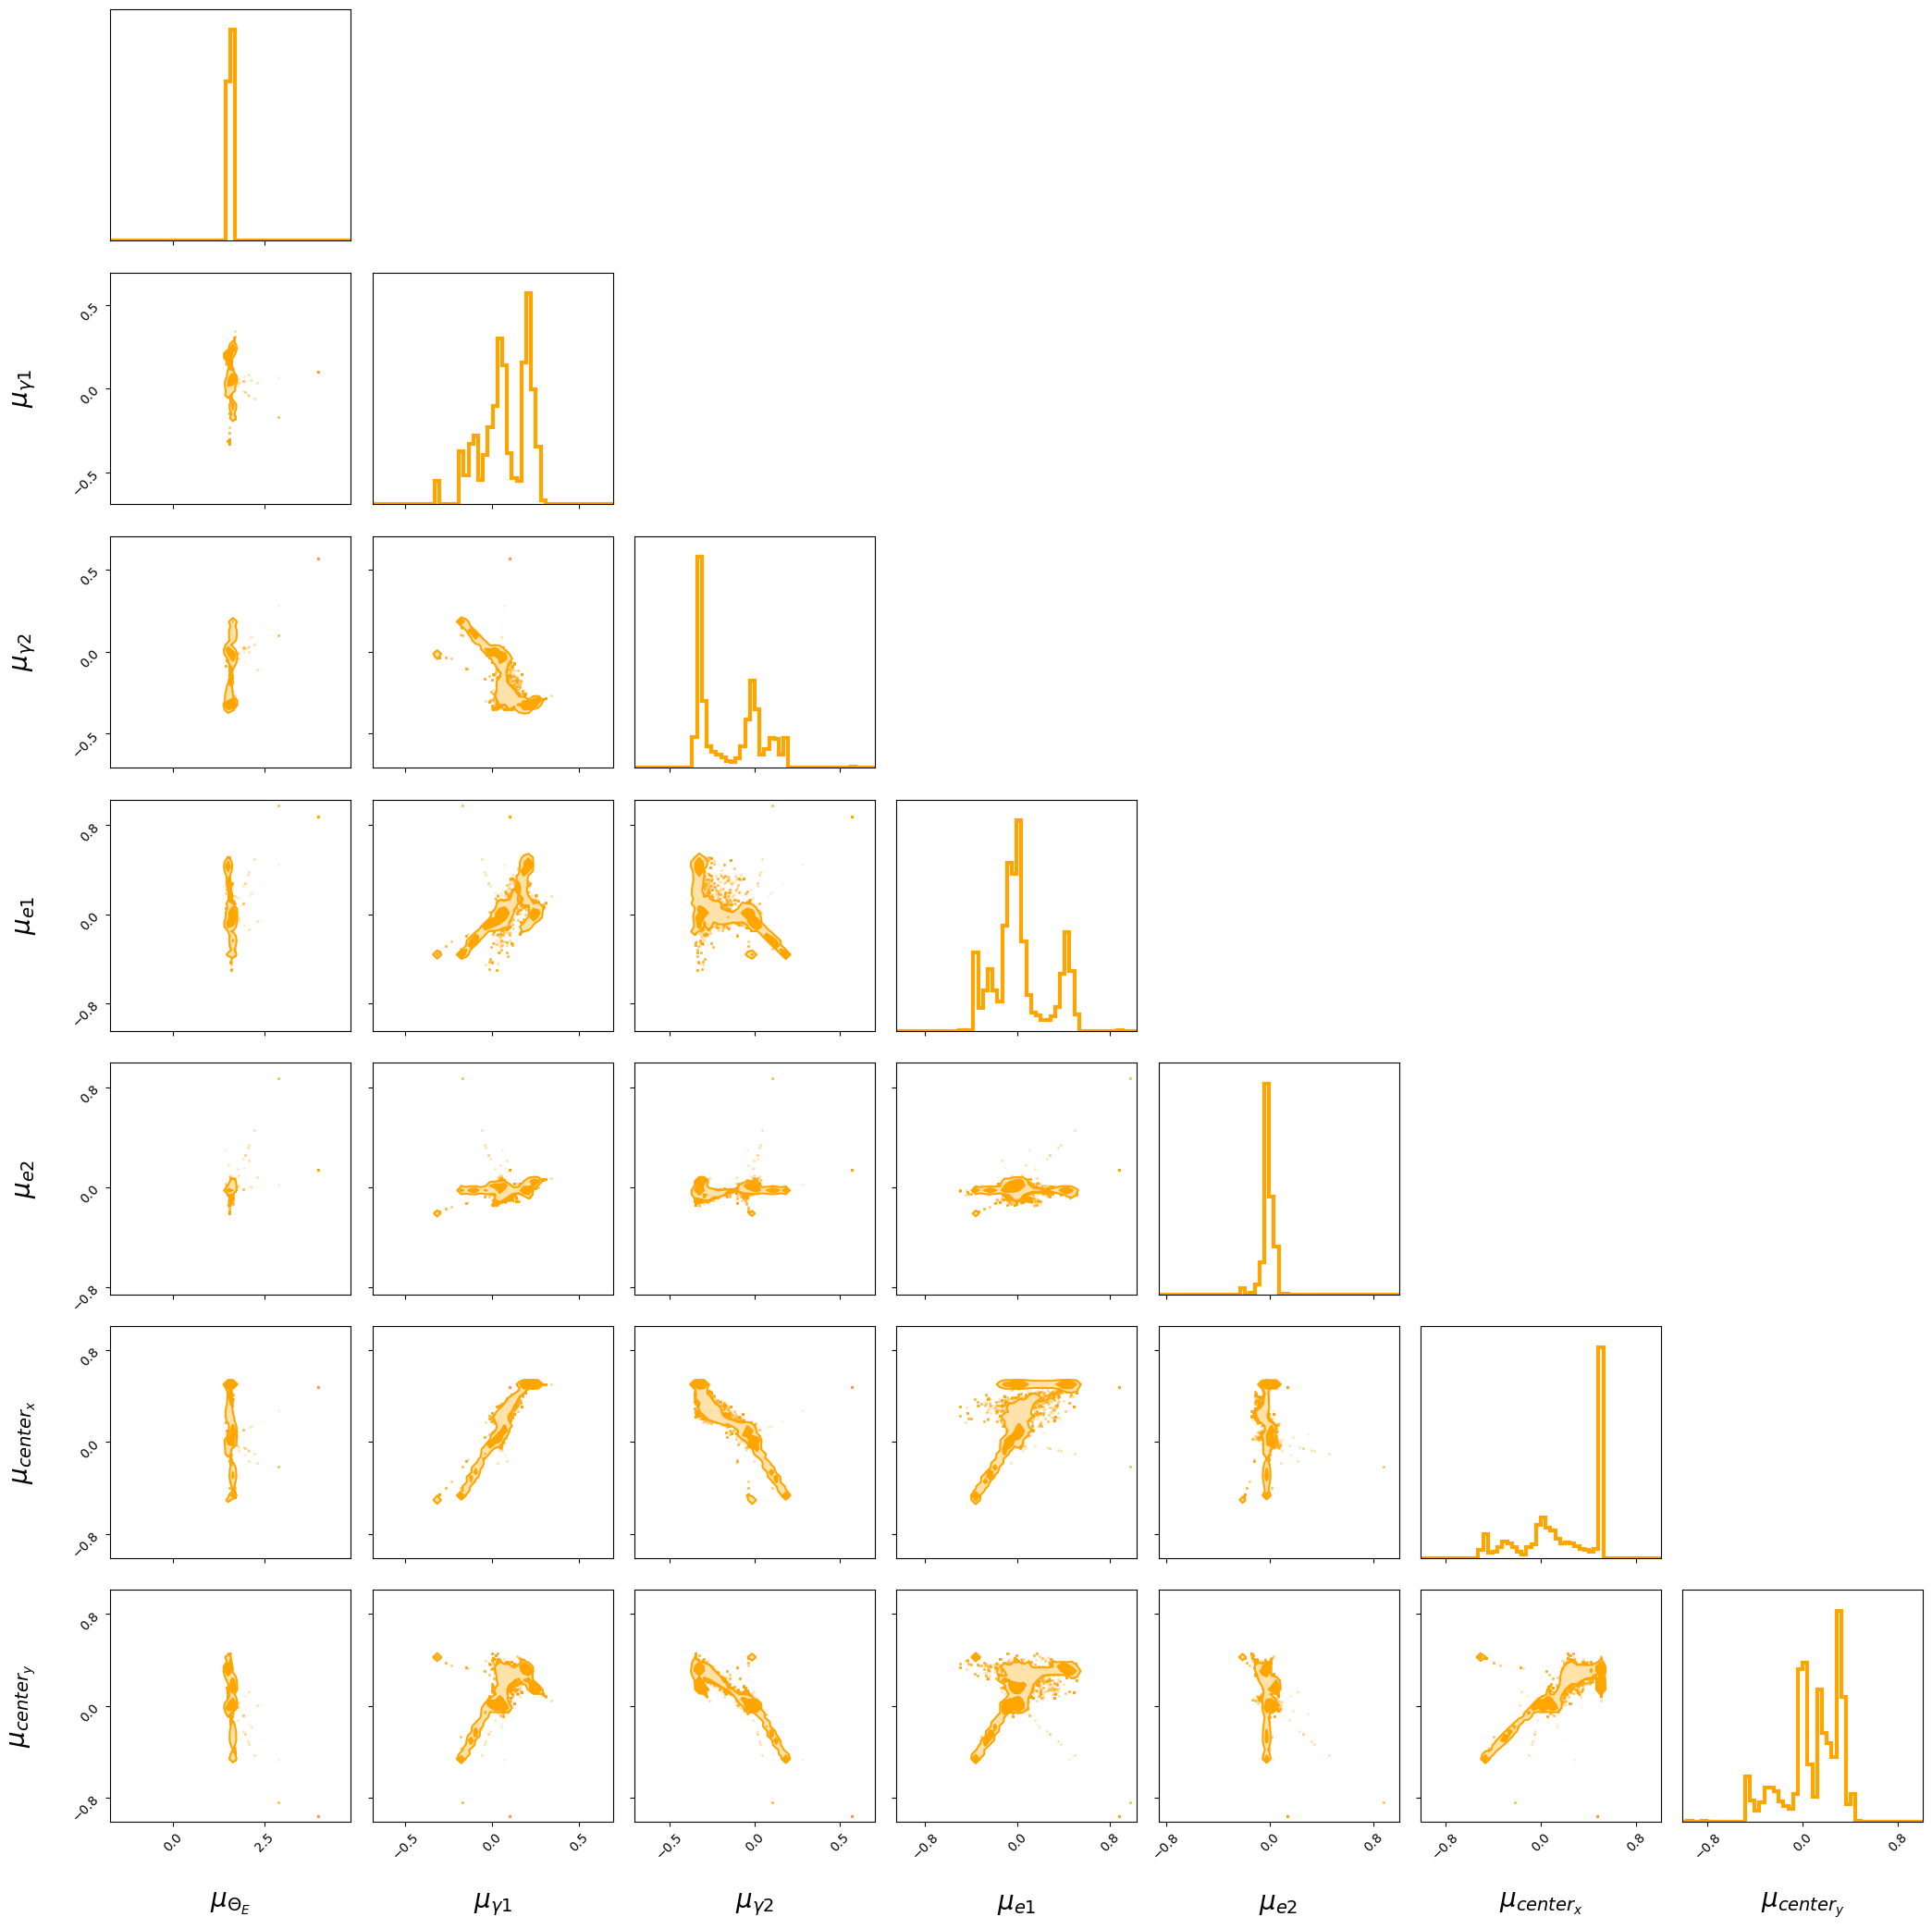

In [17]:
labels_kwargs = {'fontsize':20}
hist_kwargs = {'density':False,'color':'orange','lw':3}
fig,ax = pl.subplots(len(learning_params),len(learning_params),figsize=(3*len(learning_params),3*len(learning_params)))

f = 10 #Bounds of corner plot, in units of sigma

corner.corner(chain,
                labels=['$\mu_{'+elem+'}$' for elem in corner_param_print],
                range=[(prior_db_indx.loc[elem]['mean']-f*prior_db_indx.loc[elem]['std'],
                        prior_db_indx.loc[elem]['mean']+f*prior_db_indx.loc[elem]['std']) for elem in learning_params],
                fig=fig,
                show_titles=False,
                plot_datapoints=True,
                label_kwargs=labels_kwargs,\
                levels=[0.68,0.95],
                color='orange',
                fill_contours=True,
                hist_kwargs=hist_kwargs,
                title_fmt='.2f',\
                #truths=[1.1,0,0,0,0,0,0],
                truth_color='k',\
                max_n_ticks=3,
                bins=50,
                s=100
                )

sig_learning_params = np.array(prior_db['std'])#np.array([0.15,0.05,0.05,0.1,0.1,0.1,0.16,0.16])
loc_learning_params = np.array(prior_db['mean'])#np.array([1.1,0,0,2,0,0,0,0])
for i in range(len(learning_params)):
    for j in range(len(learning_params)):
        ax[i,j].set_xlim((loc_learning_params-f*sig_learning_params)[j],(loc_learning_params+f*sig_learning_params)[j])
        if i!=j:
            ax[i,j].set_ylim((loc_learning_params-f*sig_learning_params)[i],(loc_learning_params+f*sig_learning_params)[i])

pl.tight_layout()
pl.show()

# Endnote
We have now 1) generated simulated lensed images, 2) trained a neural network to model these images, 3) applied the trained network to a different set of images and 4) run hierarchical inference to infer population-level parameters.\
You may note that the final results could be improved - the configuration settings used here were chosen for speed rather than precision. For science-level results, the following should be changed:
1) Increase the training-set size for the neural network,
2) Increase the number of epochs the network trains for,
3) Increase the number of iterations (and burn-in) of the MCMC used for hierarchical inference.
